In [1]:
import yfinance as yf
import datetime as dt
import pandas as pd
import numpy as np
from finta import TA
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn import metrics

In [2]:
# Function to grab data from yfinance
def get_stock(symbols, start_date_list, end_date_list = []):
    """
    Pulls financial data between start and end dates for specify stock.

    Params:
        symbols         : list of stock symbols to create csv files.
        start_date_list : start date in list form (i.e. [<year>, <month>, <day>]).
        end_date_list   : end date in list form (i.e. [<year>, <month>, <day>]).  It does not include the end dates.
        interval        : sample rate of data
        
    Returns:
        Stock data between a specific interval.
    """

    start = dt.date(start_date_list[0], start_date_list[1], start_date_list[2])
    
    if end_date_list == []:
        end = dt.date.today()
    else:
        end = dt.date(end_date_list[0], end_date_list[1], end_date_list[2])

    formatted_start_date = start.strftime("%Y%m%d")
    formatted_end_date = end.strftime("%Y%m%d")

    data = yf.download(symbols, start = start, end = end)

    col_name_change = {"Close": "close", "High": "high", "Low": "low", "Volume": "volume", "Open": "open", "Adj Close": "adj_close"}
    
    data.rename(columns = col_name_change, inplace = True)

    return data

In [5]:
# Selecting Stock via Stock Symbol
symbols = "WFC"

start_date_list = [2016, 1, 1]
end_date_list = [2022, 5, 19]

# Run the stock grabber function
data = get_stock(symbols, start_date_list, end_date_list)
print(data.head())
print(data.tail())
print(data.shape)

[*********************100%***********************]  1 of 1 completed
                 open       high        low      close  adj_close    volume
Date                                                                       
2016-01-04  53.090000  53.270000  52.299999  52.910000  43.726467  25985400
2016-01-05  52.930000  53.270000  52.549999  52.889999  43.709934  14759600
2016-01-06  52.119999  52.619999  51.830002  51.880001  42.875237  20026400
2016-01-07  51.009998  51.189999  50.150002  50.400002  41.652122  30425600
2016-01-08  50.799999  50.860001  49.459999  49.560001  40.957912  22981400
                 open       high        low      close  adj_close    volume
Date                                                                       
2022-05-12  42.230000  42.410000  40.919998  41.810001  41.810001  30171700
2022-05-13  42.450001  43.189999  42.279999  42.639999  42.639999  21251600
2022-05-16  42.400002  42.669998  41.700001  42.209999  42.209999  16837400
2022-05-17  42.9900

<AxesSubplot:xlabel='Date'>

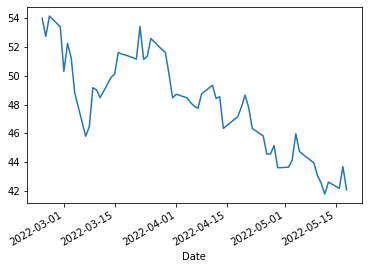

In [6]:
# Plot stock based on closing price from the last 60 days
stock_plot = data.iloc[-60:]
stock_plot['close'].plot()

In [7]:
# List of symbols for technical indicators to grab from finta library
finta_indicators = ['RSI', 'MACD', 'STOCH','ADL', 'ATR', 'MOM', 'MFI', 'ROC', 'OBV', 'CCI', 'EMV', 'VORTEX']

In [8]:
# Clean stock data and perform feature selection to create new technical indicator features that model can learn from
def exponential_smooth(data, alpha):
    """
    Function that exponentially smooths dataset so values are smoother
    """
    
    return data.ewm(alpha = alpha).mean()

<AxesSubplot:xlabel='Date'>

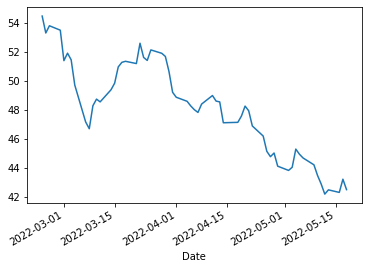

In [9]:
# Plot the smoothed out stock plot based on the last 60 days
data = exponential_smooth(data, 0.65)

stock_plot_smooth = data.iloc[-60:]
stock_plot_smooth['close'].plot()

In [10]:
# Function that uses the finta API to calculate indicators used for features
def get_indicator_data(data):
    """
    Function that uses the finta API to calculate indicators used as the features
    """

    for indicator in finta_indicators:
        ind_data = eval('TA.' + indicator + '(data)')
        if not isinstance(ind_data, pd.DataFrame):
            ind_data = ind_data.to_frame()
        data = data.merge(ind_data, left_index = True, right_index = True)
    data.rename(columns = {"14 period EMV.": '14 period EMV'}, inplace = True)

    # Also calculate moving averages for features
    data['ema50'] = data['close'] / data['close'].ewm(50).mean()
    data['ema21'] = data['close'] / data['close'].ewm(21).mean()
    data['ema15'] = data['close'] / data['close'].ewm(14).mean()
    data['ema5'] = data['close'] / data['close'].ewm(5).mean()

    # Instead of using the actual volume value (which changes over time), we normalize it with a moving volume average
    data['normVol'] = data['volume'] / data['volume'].ewm(5).mean()

    # Remove columns that won't be used as features
    data = data.drop(columns = ["open", "high", "low", "volume", "adj_close"])
    
    return data

data = get_indicator_data(data)
print(data.columns)

Index(['close', '14 period RSI', 'MACD', 'SIGNAL', '14 period STOCH %K', 'MFV',
       '14 period ATR', 'MOM', '14 period MFI', 'ROC', 'OBV', '20 period CCI',
       '14 period EMV', 'VIm', 'VIp', 'ema50', 'ema21', 'ema15', 'ema5',
       'normVol'],
      dtype='object')


In [11]:
# Function creates column of predicted values
def produce_prediction(data, window):
    """
    Function that produces predicted values.  Looks ahead a specific amt and see if the prices increase (1) or decrease (0)
    """
    
    prediction = (data.shift(-window)['close'] >= data['close'])
    prediction = prediction.iloc[:-window]
    data['pred'] = prediction.astype(int)
    
    return data

In [12]:
# Prints data with predictions and features
data = produce_prediction(data, window = 15)
del (data['close'])
data = data.dropna() # Some indicators produce NaN values for the first few rows, we just remove them here
data.tail()

,14 period RSI,MACD,SIGNAL,14 period STOCH %K,MFV,14 period ATR,MOM,14 period MFI,ROC,OBV,20 period CCI,14 period EMV,VIm,VIp,ema50,ema21,ema15,ema5,normVol,pred
Date,,,,,,,,,,,,,,,,,,,,
2022-04-21,40.452158,-0.956422,-0.978465,49.183740,-6.884774e+08,1.449394,-0.075628,26.337115,-1.350765,5.661331e+07,-41.191191,-0.006587,1.056787,0.901569,0.946282,0.956767,0.970007,0.994320,0.767431,0.0
2022-04-22,35.257761,-0.996547,-0.982082,24.428377,-7.061125e+08,1.442402,-0.936471,26.986896,-2.871732,3.506231e+07,-85.611127,-0.007723,1.051165,0.896147,0.926919,0.938560,0.952023,0.977022,0.805952,0.0
2022-04-25,32.285368,-1.072383,-1.000142,19.897465,-7.010311e+08,1.464155,-2.212763,27.003211,-3.798370,7.989879e+06,-150.580376,-0.011425,1.080360,0.843942,0.914665,0.927755,0.941739,0.968523,1.010344,0.0
2022-04-26,28.387293,-1.203907,-1.040895,6.545595,-7.140203e+08,1.484028,-3.861967,27.088053,-5.628001,-1.547828e+07,-186.267417,-0.013336,1.097634,0.824842,0.895605,0.910397,0.925116,0.954901,0.894341,0.0
2022-04-27,27.151650,-1.322749,-1.097266,7.361952,-7.209154e+08,1.508163,-3.847686,27.484345,-7.517456,-3.638072e+07,-193.201117,-0.014667,1.102084,0.818808,0.890216,0.906938,0.922607,0.955503,0.824521,0.0


In [13]:
# Function uses random forest to train model
def train_random_forest(X_train, y_train, X_test, y_test):
    # Create a new random forest classifier
    rf = RandomForestClassifier()
    
    # Dictionary of all values we want to test for n_estimators
    params_rf = {'n_estimators': [110,130,140,150,160,180,200]}
    
    # Use gridsearch to test all values for n_estimators
    rf_gs = GridSearchCV(rf, params_rf, cv=5)
    
    # Fit model to training data
    rf_gs.fit(X_train, y_train)
    
    # Save best model
    rf_best = rf_gs.best_estimator_
    
    # Check best n_estimators value
    print(rf_gs.best_params_)
    
    prediction = rf_best.predict(X_test)

    print(classification_report(y_test, prediction))
    print(confusion_matrix(y_test, prediction))
    
    return rf_best

In [14]:
# Function that uses k-nearest neighbor to train model
def train_KNN(X_train, y_train, X_test, y_test):
    # Create a new knn
    knn = KNeighborsClassifier()

    # Create a dictionary of all values we want to test for n_neighbors
    params_knn = {'n_neighbors': np.arange(1, 25)}
    
    # Use gridsearch to test all values for n_neighbors
    knn_gs = GridSearchCV(knn, params_knn, cv=5)
    
    # Fit model to training data
    knn_gs.fit(X_train, y_train)
    
    # Save best model
    knn_best = knn_gs.best_estimator_
     
    # Check best n_neigbors value
    print(knn_gs.best_params_)
    
    prediction = knn_best.predict(X_test)

    print(classification_report(y_test, prediction))
    print(confusion_matrix(y_test, prediction))
    
    return knn_best

In [15]:
# Function that runs both the random forest and the k-nearest neighbor to train both models.
def run_rf_knn(data):
    # Split data into equal partitions of size len_train
    num_train = 10 # Increment of how many starting points (len(data) / num_train  =  number of train-test sets)
    len_train = 40 # Length of each train-test set
    
    # Lists to store the results from each model
    rf_results = []
    knn_results = []
    
    i = 0
    while True:
        
        # Partition the data into chunks of size len_train every num_train days
        df = data.iloc[i * num_train : (i * num_train) + len_train]
        i += 1
        print(i * num_train, (i * num_train) + len_train)
        
        if len(df) < 40:
            break
        
        y = df['pred']
        features = [x for x in df.columns if x not in ['pred']]
        X = df[features]

        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 7 * len(X) // 10, shuffle = False)
        
        rf_model = train_random_forest(X_train, y_train, X_test, y_test)
        knn_model = train_KNN(X_train, y_train, X_test, y_test)
        
        rf_prediction = rf_model.predict(X_test)
        knn_prediction = knn_model.predict(X_test)
        
        # print('rf prediction is ', rf_prediction)
        # print('knn prediction is ', knn_prediction)
        # print('truth values are ', y_test.values)
        
        rf_accuracy = accuracy_score(y_test.values, rf_prediction)
        knn_accuracy = accuracy_score(y_test.values, knn_prediction)
        
        print(rf_accuracy, knn_accuracy)
        rf_results.append(rf_accuracy)
        knn_results.append(knn_accuracy)
        
    print('RF Accuracy = ' + str(sum(rf_results) / len(rf_results)))
    print('KNN Accuracy = ' + str(sum(knn_results) / len(knn_results)))

In [16]:
run_rf_knn(data)

10 50
{'n_estimators': 150}
              precision    recall  f1-score   support

         0.0       1.00      0.50      0.67        12
         1.0       0.00      0.00      0.00         0

    accuracy                           0.50        12
   macro avg       0.50      0.25      0.33        12
weighted avg       1.00      0.50      0.67        12

[[6 6]
 [0 0]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/

{'n_neighbors': 6}
              precision    recall  f1-score   support

         0.0       1.00      0.25      0.40        12
         1.0       0.00      0.00      0.00         0

    accuracy                           0.25        12
   macro avg       0.50      0.12      0.20        12
weighted avg       1.00      0.25      0.40        12

[[3 9]
 [0 0]]
0.5 0.25
20 60
{'n_estimators': 110}
              precision    recall  f1-score   support

         0.0       0.50      1.00      0.67         6
         1.0       0.00      0.00      0.00         6

    accuracy                           0.50        12
   macro avg       0.25      0.50      0.33        12
weighted avg       0.25      0.50      0.33        12

[[6 0]
 [6 0]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmb

{'n_neighbors': 2}
              precision    recall  f1-score   support

         0.0       0.50      1.00      0.67         6
         1.0       0.00      0.00      0.00         6

    accuracy                           0.50        12
   macro avg       0.25      0.50      0.33        12
weighted avg       0.25      0.50      0.33        12

[[6 0]
 [6 0]]
0.5 0.5
30 70
{'n_estimators': 110}
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         1
         1.0       1.00      1.00      1.00        11

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[ 1  0]
 [ 0 11]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py", line 500, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py", line 197, in predict
    neigh_dist, neigh_ind = self.kneighbors(X)
  File "/Users/rmbp2015/opt/anaconda3/lib/pytho

{'n_neighbors': 3}
              precision    recall  f1-score   support

         0.0       0.33      1.00      0.50         1
         1.0       1.00      0.82      0.90        11

    accuracy                           0.83        12
   macro avg       0.67      0.91      0.70        12
weighted avg       0.94      0.83      0.87        12

[[1 0]
 [2 9]]
1.0 0.8333333333333334
40 80
{'n_estimators': 130}
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96        11
         1.0       0.00      0.00      0.00         1

    accuracy                           0.92        12
   macro avg       0.46      0.50      0.48        12
weighted avg       0.84      0.92      0.88        12

[[11  0]
 [ 1  0]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmb

{'n_neighbors': 2}
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96        11
         1.0       0.00      0.00      0.00         1

    accuracy                           0.92        12
   macro avg       0.46      0.50      0.48        12
weighted avg       0.84      0.92      0.88        12

[[11  0]
 [ 1  0]]
0.9166666666666666 0.9166666666666666
50 90
{'n_estimators': 110}
              precision    recall  f1-score   support

         0.0       0.40      1.00      0.57         2
         1.0       1.00      0.70      0.82        10

    accuracy                           0.75        12
   macro avg       0.70      0.85      0.70        12
weighted avg       0.90      0.75      0.78        12

[[2 0]
 [3 7]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py", line 500, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py", line 197, in predict
    neigh_dist, neigh_ind = self.kneighbors(X)
  File "/Users/rmbp2015/opt/anaconda3/lib/pytho

{'n_neighbors': 13}
              precision    recall  f1-score   support

         0.0       0.25      1.00      0.40         2
         1.0       1.00      0.40      0.57        10

    accuracy                           0.50        12
   macro avg       0.62      0.70      0.49        12
weighted avg       0.88      0.50      0.54        12

[[2 0]
 [6 4]]
0.75 0.5
60 100
{'n_estimators': 110}
              precision    recall  f1-score   support

         0.0       1.00      0.62      0.77         8
         1.0       0.57      1.00      0.73         4

    accuracy                           0.75        12
   macro avg       0.79      0.81      0.75        12
weighted avg       0.86      0.75      0.76        12

[[5 3]
 [0 4]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py", line 500, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py", line 197, in predict
    neigh_dist, neigh_ind = self.kneighbors(X)
  File "/Users/rmbp2015/opt/anaconda3/lib/pytho

{'n_neighbors': 1}
              precision    recall  f1-score   support

         0.0       1.00      0.50      0.67         8
         1.0       0.50      1.00      0.67         4

    accuracy                           0.67        12
   macro avg       0.75      0.75      0.67        12
weighted avg       0.83      0.67      0.67        12

[[4 4]
 [0 4]]
0.75 0.6666666666666666
70 110
{'n_estimators': 140}
              precision    recall  f1-score   support

         0.0       1.00      0.58      0.74        12
         1.0       0.00      0.00      0.00         0

    accuracy                           0.58        12
   macro avg       0.50      0.29      0.37        12
weighted avg       1.00      0.58      0.74        12

[[7 5]
 [0 0]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/

{'n_neighbors': 2}
              precision    recall  f1-score   support

         0.0       1.00      0.75      0.86        12
         1.0       0.00      0.00      0.00         0

    accuracy                           0.75        12
   macro avg       0.50      0.38      0.43        12
weighted avg       1.00      0.75      0.86        12

[[9 3]
 [0 0]]
0.5833333333333334 0.75
80 120
{'n_estimators': 140}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         2
         1.0       0.82      0.90      0.86        10

    accuracy                           0.75        12
   macro avg       0.41      0.45      0.43        12
weighted avg       0.68      0.75      0.71        12

[[0 2]
 [1 9]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py", line 500, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py", line 197, in predict
    neigh_dist, neigh_ind = self.kneighbors(X)
  File "/Users/rmbp2015/opt/anaconda3/lib/pytho

{'n_neighbors': 18}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         2
         1.0       0.83      1.00      0.91        10

    accuracy                           0.83        12
   macro avg       0.42      0.50      0.45        12
weighted avg       0.69      0.83      0.76        12

[[ 0  2]
 [ 0 10]]
0.75 0.8333333333333334
90 130
{'n_estimators': 150}
              precision    recall  f1-score   support

         0.0       0.30      1.00      0.46         3
         1.0       1.00      0.22      0.36         9

    accuracy                           0.42        12
   macro avg       0.65      0.61      0.41        12
weighted avg       0.83      0.42      0.39        12

[[3 0]
 [7 2]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py", line 500, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py", line 197, in predict
    neigh_dist, neigh_ind = self.kneighbors(X)
  File "/Users/rmbp2015/opt/anaconda3/lib/pytho

{'n_neighbors': 1}
              precision    recall  f1-score   support

         0.0       0.43      1.00      0.60         3
         1.0       1.00      0.56      0.71         9

    accuracy                           0.67        12
   macro avg       0.71      0.78      0.66        12
weighted avg       0.86      0.67      0.69        12

[[3 0]
 [4 5]]
0.4166666666666667 0.6666666666666666
100 140
{'n_estimators': 130}
              precision    recall  f1-score   support

         0.0       0.50      1.00      0.67         6
         1.0       0.00      0.00      0.00         6

    accuracy                           0.50        12
   macro avg       0.25      0.50      0.33        12
weighted avg       0.25      0.50      0.33        12

[[6 0]
 [6 0]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmb

{'n_neighbors': 11}
              precision    recall  f1-score   support

         0.0       0.50      1.00      0.67         6
         1.0       0.00      0.00      0.00         6

    accuracy                           0.50        12
   macro avg       0.25      0.50      0.33        12
weighted avg       0.25      0.50      0.33        12

[[6 0]
 [6 0]]
0.5 0.5
110 150
{'n_estimators': 140}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.75      0.86        12

    accuracy                           0.75        12
   macro avg       0.50      0.38      0.43        12
weighted avg       1.00      0.75      0.86        12

[[0 0]
 [3 9]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/

{'n_neighbors': 3}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.83      0.91        12

    accuracy                           0.83        12
   macro avg       0.50      0.42      0.45        12
weighted avg       1.00      0.83      0.91        12

[[ 0  0]
 [ 2 10]]
0.75 0.8333333333333334
120 160
{'n_estimators': 200}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         4
         1.0       0.67      1.00      0.80         8

    accuracy                           0.67        12
   macro avg       0.33      0.50      0.40        12
weighted avg       0.44      0.67      0.53        12

[[0 4]
 [0 8]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmb

{'n_neighbors': 5}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         4
         1.0       0.67      1.00      0.80         8

    accuracy                           0.67        12
   macro avg       0.33      0.50      0.40        12
weighted avg       0.44      0.67      0.53        12

[[0 4]
 [0 8]]
0.6666666666666666 0.6666666666666666
130 170
{'n_estimators': 110}
              precision    recall  f1-score   support

         0.0       1.00      0.67      0.80        12
         1.0       0.00      0.00      0.00         0

    accuracy                           0.67        12
   macro avg       0.50      0.33      0.40        12
weighted avg       1.00      0.67      0.80        12

[[8 4]
 [0 0]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/

{'n_neighbors': 8}
              precision    recall  f1-score   support

         0.0       1.00      0.42      0.59        12
         1.0       0.00      0.00      0.00         0

    accuracy                           0.42        12
   macro avg       0.50      0.21      0.29        12
weighted avg       1.00      0.42      0.59        12

[[5 7]
 [0 0]]
0.6666666666666666 0.4166666666666667
140 180
{'n_estimators': 110}
              precision    recall  f1-score   support

         0.0       1.00      0.25      0.40        12
         1.0       0.00      0.00      0.00         0

    accuracy                           0.25        12
   macro avg       0.50      0.12      0.20        12
weighted avg       1.00      0.25      0.40        12

[[3 9]
 [0 0]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/

{'n_neighbors': 1}
              precision    recall  f1-score   support

         0.0       1.00      0.17      0.29        12
         1.0       0.00      0.00      0.00         0

    accuracy                           0.17        12
   macro avg       0.50      0.08      0.14        12
weighted avg       1.00      0.17      0.29        12

[[ 2 10]
 [ 0  0]]
0.25 0.16666666666666666
150 190
{'n_estimators': 110}
              precision    recall  f1-score   support

         0.0       0.42      1.00      0.59         5
         1.0       0.00      0.00      0.00         7

    accuracy                           0.42        12
   macro avg       0.21      0.50      0.29        12
weighted avg       0.17      0.42      0.25        12

[[5 0]
 [7 0]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmb

{'n_neighbors': 6}
              precision    recall  f1-score   support

         0.0       0.42      1.00      0.59         5
         1.0       0.00      0.00      0.00         7

    accuracy                           0.42        12
   macro avg       0.21      0.50      0.29        12
weighted avg       0.17      0.42      0.25        12

[[5 0]
 [7 0]]
0.4166666666666667 0.4166666666666667
160 200
{'n_estimators': 110}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.08      0.15        12

    accuracy                           0.08        12
   macro avg       0.50      0.04      0.08        12
weighted avg       1.00      0.08      0.15        12

[[ 0  0]
 [11  1]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/

{'n_neighbors': 4}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.92      0.96        12

    accuracy                           0.92        12
   macro avg       0.50      0.46      0.48        12
weighted avg       1.00      0.92      0.96        12

[[ 0  0]
 [ 1 11]]
0.08333333333333333 0.9166666666666666
170 210
{'n_estimators': 110}
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py", line 500, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py", line 197, in predict
    neigh_dist, neigh_ind = self.kneighbors(X)
  File "/Users/rmbp2015/opt/anaconda3/lib/pytho

{'n_neighbors': 1}
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
1.0 1.0
180 220
{'n_estimators': 110}
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py", line 500, in score
    return accuracy_score(y, self.predict

{'n_neighbors': 3}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.42      0.59        12

    accuracy                           0.42        12
   macro avg       0.50      0.21      0.29        12
weighted avg       1.00      0.42      0.59        12

[[0 0]
 [7 5]]
1.0 0.4166666666666667
190 230
{'n_estimators': 110}
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py", line 500, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py", line 197, in predict
    neigh_dist, neigh_ind = self.kneighbors(X)
  File "/Users/rmbp2015/opt/anaconda3/lib/pytho

{'n_neighbors': 1}
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
1.0 1.0
200 240
{'n_estimators': 110}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         8
         1.0       0.33      1.00      0.50         4

    accuracy                           0.33        12
   macro avg       0.17      0.50      0.25        12
weighted avg       0.11      0.33      0.17        12

[[0 8]
 [0 4]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmb

{'n_neighbors': 1}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         8
         1.0       0.33      1.00      0.50         4

    accuracy                           0.33        12
   macro avg       0.17      0.50      0.25        12
weighted avg       0.11      0.33      0.17        12

[[0 8]
 [0 4]]
0.3333333333333333 0.3333333333333333
210 250
{'n_estimators': 130}
              precision    recall  f1-score   support

         0.0       1.00      0.30      0.46        10
         1.0       0.22      1.00      0.36         2

    accuracy                           0.42        12
   macro avg       0.61      0.65      0.41        12
weighted avg       0.87      0.42      0.45        12

[[3 7]
 [0 2]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py", line 500, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py", line 197, in predict
    neigh_dist, neigh_ind = self.kneighbors(X)
  File "/Users/rmbp2015/opt/anaconda3/lib/pytho

{'n_neighbors': 1}
              precision    recall  f1-score   support

         0.0       0.83      1.00      0.91        10
         1.0       0.00      0.00      0.00         2

    accuracy                           0.83        12
   macro avg       0.42      0.50      0.45        12
weighted avg       0.69      0.83      0.76        12

[[10  0]
 [ 2  0]]
0.4166666666666667 0.8333333333333334
220 260
{'n_estimators': 130}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       0.0
         1.0       0.00      0.00      0.00      12.0

    accuracy                           0.00      12.0
   macro avg       0.00      0.00      0.00      12.0
weighted avg       0.00      0.00      0.00      12.0

[[ 0  0]
 [12  0]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/op

{'n_neighbors': 1}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       0.0
         1.0       0.00      0.00      0.00      12.0

    accuracy                           0.00      12.0
   macro avg       0.00      0.00      0.00      12.0
weighted avg       0.00      0.00      0.00      12.0

[[ 0  0]
 [12  0]]
0.0 0.0
230 270
{'n_estimators': 110}
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py", line 500, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py", line 197, in predict
    neigh_dist, neigh_ind = self.kneighbors(X)
  File "/Users/rmbp2015/opt/anaconda3/lib/pytho

{'n_neighbors': 11}
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
1.0 1.0
240 280
{'n_estimators': 110}
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py", line 500, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py", line 197, in predict
    neigh_dist, neigh_ind = self.kneighbors(X)
  File "/Users/rmbp2015/opt/anaconda3/lib/pytho

{'n_neighbors': 9}
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
1.0 1.0
250 290
{'n_estimators': 110}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         4
         1.0       0.67      1.00      0.80         8

    accuracy                           0.67        12
   macro avg       0.33      0.50      0.40        12
weighted avg       0.44      0.67      0.53        12

[[0 4]
 [0 8]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmb

{'n_neighbors': 1}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         4
         1.0       0.67      1.00      0.80         8

    accuracy                           0.67        12
   macro avg       0.33      0.50      0.40        12
weighted avg       0.44      0.67      0.53        12

[[0 4]
 [0 8]]
0.6666666666666666 0.6666666666666666
260 300
{'n_estimators': 200}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      12.0
         1.0       0.00      0.00      0.00       0.0

    accuracy                           0.00      12.0
   macro avg       0.00      0.00      0.00      12.0
weighted avg       0.00      0.00      0.00      12.0

[[ 0 12]
 [ 0  0]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/op

{'n_neighbors': 5}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      12.0
         1.0       0.00      0.00      0.00       0.0

    accuracy                           0.00      12.0
   macro avg       0.00      0.00      0.00      12.0
weighted avg       0.00      0.00      0.00      12.0

[[ 0 12]
 [ 0  0]]
0.0 0.0
270 310
{'n_estimators': 140}
              precision    recall  f1-score   support

         0.0       1.00      0.33      0.50        12
         1.0       0.00      0.00      0.00         0

    accuracy                           0.33        12
   macro avg       0.50      0.17      0.25        12
weighted avg       1.00      0.33      0.50        12

[[4 8]
 [0 0]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/

{'n_neighbors': 17}
              precision    recall  f1-score   support

         0.0       1.00      0.17      0.29        12
         1.0       0.00      0.00      0.00         0

    accuracy                           0.17        12
   macro avg       0.50      0.08      0.14        12
weighted avg       1.00      0.17      0.29        12

[[ 2 10]
 [ 0  0]]
0.3333333333333333 0.16666666666666666
280 320
{'n_estimators': 110}
              precision    recall  f1-score   support

         0.0       0.67      1.00      0.80         8
         1.0       0.00      0.00      0.00         4

    accuracy                           0.67        12
   macro avg       0.33      0.50      0.40        12
weighted avg       0.44      0.67      0.53        12

[[8 0]
 [4 0]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmb

{'n_neighbors': 6}
              precision    recall  f1-score   support

         0.0       0.67      1.00      0.80         8
         1.0       0.00      0.00      0.00         4

    accuracy                           0.67        12
   macro avg       0.33      0.50      0.40        12
weighted avg       0.44      0.67      0.53        12

[[8 0]
 [4 0]]
0.6666666666666666 0.6666666666666666
290 330
{'n_estimators': 140}
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         6
         1.0       1.00      1.00      1.00         6

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[6 0]
 [0 6]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py", line 500, in score
    return accuracy_score(y, self.predict

{'n_neighbors': 4}
              precision    recall  f1-score   support

         0.0       0.50      1.00      0.67         6
         1.0       0.00      0.00      0.00         6

    accuracy                           0.50        12
   macro avg       0.25      0.50      0.33        12
weighted avg       0.25      0.50      0.33        12

[[6 0]
 [6 0]]
1.0 0.5
300 340
{'n_estimators': 110}
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py", line 500, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py", line 197, in predict
    neigh_dist, neigh_ind = self.kneighbors(X)
  File "/Users/rmbp2015/opt/anaconda3/lib/pytho

{'n_neighbors': 8}
              precision    recall  f1-score   support

         0.0       1.00      0.83      0.91        12
         1.0       0.00      0.00      0.00         0

    accuracy                           0.83        12
   macro avg       0.50      0.42      0.45        12
weighted avg       1.00      0.83      0.91        12

[[10  2]
 [ 0  0]]
1.0 0.8333333333333334
310 350
{'n_estimators': 110}
              precision    recall  f1-score   support

         0.0       0.30      0.75      0.43         4
         1.0       0.50      0.12      0.20         8

    accuracy                           0.33        12
   macro avg       0.40      0.44      0.31        12
weighted avg       0.43      0.33      0.28        12

[[3 1]
 [7 1]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py", line 500, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py", line 197, in predict
    neigh_dist, neigh_ind = self.kneighbors(X)
  File "/Users/rmbp2015/opt/anaconda3/lib/pytho

{'n_neighbors': 10}
              precision    recall  f1-score   support

         0.0       1.00      0.25      0.40         4
         1.0       0.73      1.00      0.84         8

    accuracy                           0.75        12
   macro avg       0.86      0.62      0.62        12
weighted avg       0.82      0.75      0.69        12

[[1 3]
 [0 8]]
0.3333333333333333 0.75
320 360
{'n_estimators': 110}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.33      0.50        12

    accuracy                           0.33        12
   macro avg       0.50      0.17      0.25        12
weighted avg       1.00      0.33      0.50        12

[[0 0]
 [8 4]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/

{'n_neighbors': 3}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.92      0.96        12

    accuracy                           0.92        12
   macro avg       0.50      0.46      0.48        12
weighted avg       1.00      0.92      0.96        12

[[ 0  0]
 [ 1 11]]
0.3333333333333333 0.9166666666666666
330 370
{'n_estimators': 140}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       0.0
         1.0       0.00      0.00      0.00      12.0

    accuracy                           0.00      12.0
   macro avg       0.00      0.00      0.00      12.0
weighted avg       0.00      0.00      0.00      12.0

[[ 0  0]
 [12  0]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/op

{'n_neighbors': 9}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.83      0.91        12

    accuracy                           0.83        12
   macro avg       0.50      0.42      0.45        12
weighted avg       1.00      0.83      0.91        12

[[ 0  0]
 [ 2 10]]
0.0 0.8333333333333334
340 380
{'n_estimators': 150}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         9
         1.0       0.25      1.00      0.40         3

    accuracy                           0.25        12
   macro avg       0.12      0.50      0.20        12
weighted avg       0.06      0.25      0.10        12

[[0 9]
 [0 3]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmb

{'n_neighbors': 3}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         9
         1.0       0.25      1.00      0.40         3

    accuracy                           0.25        12
   macro avg       0.12      0.50      0.20        12
weighted avg       0.06      0.25      0.10        12

[[0 9]
 [0 3]]
0.25 0.25
350 390
{'n_estimators': 110}
              precision    recall  f1-score   support

         0.0       1.00      0.33      0.50        12
         1.0       0.00      0.00      0.00         0

    accuracy                           0.33        12
   macro avg       0.50      0.17      0.25        12
weighted avg       1.00      0.33      0.50        12

[[4 8]
 [0 0]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/

{'n_neighbors': 1}
              precision    recall  f1-score   support

         0.0       1.00      0.50      0.67        12
         1.0       0.00      0.00      0.00         0

    accuracy                           0.50        12
   macro avg       0.50      0.25      0.33        12
weighted avg       1.00      0.50      0.67        12

[[6 6]
 [0 0]]
0.3333333333333333 0.5
360 400
{'n_estimators': 160}
              precision    recall  f1-score   support

         0.0       1.00      0.50      0.67        12
         1.0       0.00      0.00      0.00         0

    accuracy                           0.50        12
   macro avg       0.50      0.25      0.33        12
weighted avg       1.00      0.50      0.67        12

[[6 6]
 [0 0]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/

{'n_neighbors': 3}
              precision    recall  f1-score   support

         0.0       1.00      0.08      0.15        12
         1.0       0.00      0.00      0.00         0

    accuracy                           0.08        12
   macro avg       0.50      0.04      0.08        12
weighted avg       1.00      0.08      0.15        12

[[ 1 11]
 [ 0  0]]
0.5 0.08333333333333333
370 410
{'n_estimators': 110}
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py", line 500, in score
    return accuracy_score(y, self.predict

{'n_neighbors': 2}
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
1.0 1.0
380 420
{'n_estimators': 110}
              precision    recall  f1-score   support

         0.0       0.25      1.00      0.40         3
         1.0       0.00      0.00      0.00         9

    accuracy                           0.25        12
   macro avg       0.12      0.50      0.20        12
weighted avg       0.06      0.25      0.10        12

[[3 0]
 [9 0]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmb

{'n_neighbors': 1}
              precision    recall  f1-score   support

         0.0       0.25      1.00      0.40         3
         1.0       0.00      0.00      0.00         9

    accuracy                           0.25        12
   macro avg       0.12      0.50      0.20        12
weighted avg       0.06      0.25      0.10        12

[[3 0]
 [9 0]]
0.25 0.25
390 430
{'n_estimators': 110}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.67      0.80        12

    accuracy                           0.67        12
   macro avg       0.50      0.33      0.40        12
weighted avg       1.00      0.67      0.80        12

[[0 0]
 [4 8]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/

{'n_neighbors': 2}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.92      0.96        12

    accuracy                           0.92        12
   macro avg       0.50      0.46      0.48        12
weighted avg       1.00      0.92      0.96        12

[[ 0  0]
 [ 1 11]]
0.6666666666666666 0.9166666666666666
400 440
{'n_estimators': 130}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         7
         1.0       0.42      1.00      0.59         5

    accuracy                           0.42        12
   macro avg       0.21      0.50      0.29        12
weighted avg       0.17      0.42      0.25        12

[[0 7]
 [0 5]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmb

{'n_neighbors': 1}
              precision    recall  f1-score   support

         0.0       0.67      0.86      0.75         7
         1.0       0.67      0.40      0.50         5

    accuracy                           0.67        12
   macro avg       0.67      0.63      0.62        12
weighted avg       0.67      0.67      0.65        12

[[6 1]
 [3 2]]
0.4166666666666667 0.6666666666666666
410 450
{'n_estimators': 110}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.42      0.59        12

    accuracy                           0.42        12
   macro avg       0.50      0.21      0.29        12
weighted avg       1.00      0.42      0.59        12

[[0 0]
 [7 5]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/

{'n_neighbors': 9}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       0.0
         1.0       0.00      0.00      0.00      12.0

    accuracy                           0.00      12.0
   macro avg       0.00      0.00      0.00      12.0
weighted avg       0.00      0.00      0.00      12.0

[[ 0  0]
 [12  0]]
0.4166666666666667 0.0
420 460
{'n_estimators': 110}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        10
         1.0       0.17      1.00      0.29         2

    accuracy                           0.17        12
   macro avg       0.08      0.50      0.14        12
weighted avg       0.03      0.17      0.05        12

[[ 0 10]
 [ 0  2]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmb

{'n_neighbors': 10}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      10.0
         1.0       0.00      0.00      0.00       2.0

    accuracy                           0.00      12.0
   macro avg       0.00      0.00      0.00      12.0
weighted avg       0.00      0.00      0.00      12.0

[[ 0 10]
 [ 2  0]]
0.16666666666666666 0.0
430 470
{'n_estimators': 140}
              precision    recall  f1-score   support

         0.0       0.33      0.75      0.46         4
         1.0       0.67      0.25      0.36         8

    accuracy                           0.42        12
   macro avg       0.50      0.50      0.41        12
weighted avg       0.56      0.42      0.40        12

[[3 1]
 [6 2]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py", line 500, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py", line 197, in predict
    neigh_dist, neigh_ind = self.kneighbors(X)
  File "/Users/rmbp2015/opt/anaconda3/lib/pytho

{'n_neighbors': 3}
              precision    recall  f1-score   support

         0.0       0.33      1.00      0.50         4
         1.0       0.00      0.00      0.00         8

    accuracy                           0.33        12
   macro avg       0.17      0.50      0.25        12
weighted avg       0.11      0.33      0.17        12

[[4 0]
 [8 0]]
0.4166666666666667 0.3333333333333333
440 480
{'n_estimators': 110}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.67      0.80        12

    accuracy                           0.67        12
   macro avg       0.50      0.33      0.40        12
weighted avg       1.00      0.67      0.80        12

[[0 0]
 [4 8]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/

{'n_neighbors': 13}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.92      0.96        12

    accuracy                           0.92        12
   macro avg       0.50      0.46      0.48        12
weighted avg       1.00      0.92      0.96        12

[[ 0  0]
 [ 1 11]]
0.6666666666666666 0.9166666666666666
450 490
{'n_estimators': 140}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       0.0
         1.0       0.00      0.00      0.00      12.0

    accuracy                           0.00      12.0
   macro avg       0.00      0.00      0.00      12.0
weighted avg       0.00      0.00      0.00      12.0

[[ 0  0]
 [12  0]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/op

{'n_neighbors': 7}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.25      0.40        12

    accuracy                           0.25        12
   macro avg       0.50      0.12      0.20        12
weighted avg       1.00      0.25      0.40        12

[[0 0]
 [9 3]]
0.0 0.25
460 500
{'n_estimators': 130}
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py", line 500, in score
    return accuracy_score(y, self.predict

{'n_neighbors': 5}
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
1.0 1.0
470 510
{'n_estimators': 110}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         3
         1.0       0.75      1.00      0.86         9

    accuracy                           0.75        12
   macro avg       0.38      0.50      0.43        12
weighted avg       0.56      0.75      0.64        12

[[0 3]
 [0 9]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmb

{'n_neighbors': 1}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         3
         1.0       0.75      1.00      0.86         9

    accuracy                           0.75        12
   macro avg       0.38      0.50      0.43        12
weighted avg       0.56      0.75      0.64        12

[[0 3]
 [0 9]]
0.75 0.75
480 520
{'n_estimators': 110}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      12.0
         1.0       0.00      0.00      0.00       0.0

    accuracy                           0.00      12.0
   macro avg       0.00      0.00      0.00      12.0
weighted avg       0.00      0.00      0.00      12.0

[[ 0 12]
 [ 0  0]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/op

{'n_neighbors': 3}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      12.0
         1.0       0.00      0.00      0.00       0.0

    accuracy                           0.00      12.0
   macro avg       0.00      0.00      0.00      12.0
weighted avg       0.00      0.00      0.00      12.0

[[ 0 12]
 [ 0  0]]
0.0 0.0
490 530
{'n_estimators': 130}
              precision    recall  f1-score   support

         0.0       1.00      0.50      0.67         8
         1.0       0.50      1.00      0.67         4

    accuracy                           0.67        12
   macro avg       0.75      0.75      0.67        12
weighted avg       0.83      0.67      0.67        12

[[4 4]
 [0 4]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py", line 500, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py", line 197, in predict
    neigh_dist, neigh_ind = self.kneighbors(X)
  File "/Users/rmbp2015/opt/anaconda3/lib/pytho

{'n_neighbors': 9}
              precision    recall  f1-score   support

         0.0       1.00      0.50      0.67         8
         1.0       0.50      1.00      0.67         4

    accuracy                           0.67        12
   macro avg       0.75      0.75      0.67        12
weighted avg       0.83      0.67      0.67        12

[[4 4]
 [0 4]]
0.6666666666666666 0.6666666666666666
500 540
{'n_estimators': 200}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      12.0
         1.0       0.00      0.00      0.00       0.0

    accuracy                           0.00      12.0
   macro avg       0.00      0.00      0.00      12.0
weighted avg       0.00      0.00      0.00      12.0

[[ 0 12]
 [ 0  0]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/op

{'n_neighbors': 4}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      12.0
         1.0       0.00      0.00      0.00       0.0

    accuracy                           0.00      12.0
   macro avg       0.00      0.00      0.00      12.0
weighted avg       0.00      0.00      0.00      12.0

[[ 0 12]
 [ 0  0]]
0.0 0.0
510 550
{'n_estimators': 110}
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py", line 500, in score
    return accuracy_score(y, self.predict

{'n_neighbors': 1}
              precision    recall  f1-score   support

         0.0       1.00      0.58      0.74        12
         1.0       0.00      0.00      0.00         0

    accuracy                           0.58        12
   macro avg       0.50      0.29      0.37        12
weighted avg       1.00      0.58      0.74        12

[[7 5]
 [0 0]]
1.0 0.5833333333333334
520 560
{'n_estimators': 110}
              precision    recall  f1-score   support

         0.0       1.00      0.58      0.74        12
         1.0       0.00      0.00      0.00         0

    accuracy                           0.58        12
   macro avg       0.50      0.29      0.37        12
weighted avg       1.00      0.58      0.74        12

[[7 5]
 [0 0]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/

{'n_neighbors': 2}
              precision    recall  f1-score   support

         0.0       1.00      0.92      0.96        12
         1.0       0.00      0.00      0.00         0

    accuracy                           0.92        12
   macro avg       0.50      0.46      0.48        12
weighted avg       1.00      0.92      0.96        12

[[11  1]
 [ 0  0]]
0.5833333333333334 0.9166666666666666
530 570
{'n_estimators': 110}
              precision    recall  f1-score   support

         0.0       0.58      1.00      0.74         7
         1.0       0.00      0.00      0.00         5

    accuracy                           0.58        12
   macro avg       0.29      0.50      0.37        12
weighted avg       0.34      0.58      0.43        12

[[7 0]
 [5 0]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmb

{'n_neighbors': 1}
              precision    recall  f1-score   support

         0.0       0.58      1.00      0.74         7
         1.0       0.00      0.00      0.00         5

    accuracy                           0.58        12
   macro avg       0.29      0.50      0.37        12
weighted avg       0.34      0.58      0.43        12

[[7 0]
 [5 0]]
0.5833333333333334 0.5833333333333334
540 580
{'n_estimators': 140}
              precision    recall  f1-score   support

         0.0       0.08      1.00      0.15         1
         1.0       0.00      0.00      0.00        11

    accuracy                           0.08        12
   macro avg       0.04      0.50      0.08        12
weighted avg       0.01      0.08      0.01        12

[[ 1  0]
 [11  0]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmb

{'n_neighbors': 6}
              precision    recall  f1-score   support

         0.0       0.08      1.00      0.15         1
         1.0       0.00      0.00      0.00        11

    accuracy                           0.08        12
   macro avg       0.04      0.50      0.08        12
weighted avg       0.01      0.08      0.01        12

[[ 1  0]
 [11  0]]
0.08333333333333333 0.08333333333333333
550 590
{'n_estimators': 140}
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py", line 500, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py", line 197, in predict
    neigh_dist, neigh_ind = self.kneighbors(X)
  File "/Users/rmbp2015/opt/anaconda3/lib/pytho

{'n_neighbors': 8}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.83      0.91        12

    accuracy                           0.83        12
   macro avg       0.50      0.42      0.45        12
weighted avg       1.00      0.83      0.91        12

[[ 0  0]
 [ 2 10]]
1.0 0.8333333333333334
560 600
{'n_estimators': 110}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         2
         1.0       0.83      1.00      0.91        10

    accuracy                           0.83        12
   macro avg       0.42      0.50      0.45        12
weighted avg       0.69      0.83      0.76        12

[[ 0  2]
 [ 0 10]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmb

{'n_neighbors': 6}
              precision    recall  f1-score   support

         0.0       0.22      1.00      0.36         2
         1.0       1.00      0.30      0.46        10

    accuracy                           0.42        12
   macro avg       0.61      0.65      0.41        12
weighted avg       0.87      0.42      0.45        12

[[2 0]
 [7 3]]
0.8333333333333334 0.4166666666666667
570 610
{'n_estimators': 110}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         7
         1.0       0.42      1.00      0.59         5

    accuracy                           0.42        12
   macro avg       0.21      0.50      0.29        12
weighted avg       0.17      0.42      0.25        12

[[0 7]
 [0 5]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmb

{'n_neighbors': 3}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         7
         1.0       0.42      1.00      0.59         5

    accuracy                           0.42        12
   macro avg       0.21      0.50      0.29        12
weighted avg       0.17      0.42      0.25        12

[[0 7]
 [0 5]]
0.4166666666666667 0.4166666666666667
580 620
{'n_estimators': 110}
              precision    recall  f1-score   support

         0.0       0.17      1.00      0.29         1
         1.0       1.00      0.55      0.71        11

    accuracy                           0.58        12
   macro avg       0.58      0.77      0.50        12
weighted avg       0.93      0.58      0.67        12

[[1 0]
 [5 6]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py", line 500, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py", line 197, in predict
    neigh_dist, neigh_ind = self.kneighbors(X)
  File "/Users/rmbp2015/opt/anaconda3/lib/pytho

{'n_neighbors': 13}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         1
         1.0       0.92      1.00      0.96        11

    accuracy                           0.92        12
   macro avg       0.46      0.50      0.48        12
weighted avg       0.84      0.92      0.88        12

[[ 0  1]
 [ 0 11]]
0.5833333333333334 0.9166666666666666
590 630
{'n_estimators': 130}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.42      0.59        12

    accuracy                           0.42        12
   macro avg       0.50      0.21      0.29        12
weighted avg       1.00      0.42      0.59        12

[[0 0]
 [7 5]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/

{'n_neighbors': 9}
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
0.4166666666666667 1.0
600 640
{'n_estimators': 150}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         1
         1.0       0.92      1.00      0.96        11

    accuracy                           0.92        12
   macro avg       0.46      0.50      0.48        12
weighted avg       0.84      0.92      0.88        12

[[ 0  1]
 [ 0 11]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmb

{'n_neighbors': 9}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         1
         1.0       0.92      1.00      0.96        11

    accuracy                           0.92        12
   macro avg       0.46      0.50      0.48        12
weighted avg       0.84      0.92      0.88        12

[[ 0  1]
 [ 0 11]]
0.9166666666666666 0.9166666666666666
610 650
{'n_estimators': 110}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         2
         1.0       0.83      1.00      0.91        10

    accuracy                           0.83        12
   macro avg       0.42      0.50      0.45        12
weighted avg       0.69      0.83      0.76        12

[[ 0  2]
 [ 0 10]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmb

{'n_neighbors': 1}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         2
         1.0       0.83      1.00      0.91        10

    accuracy                           0.83        12
   macro avg       0.42      0.50      0.45        12
weighted avg       0.69      0.83      0.76        12

[[ 0  2]
 [ 0 10]]
0.8333333333333334 0.8333333333333334
620 660
{'n_estimators': 150}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         6
         1.0       0.50      1.00      0.67         6

    accuracy                           0.50        12
   macro avg       0.25      0.50      0.33        12
weighted avg       0.25      0.50      0.33        12

[[0 6]
 [0 6]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmb

{'n_neighbors': 5}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         6
         1.0       0.50      1.00      0.67         6

    accuracy                           0.50        12
   macro avg       0.25      0.50      0.33        12
weighted avg       0.25      0.50      0.33        12

[[0 6]
 [0 6]]
0.5 0.5
630 670
{'n_estimators': 200}
              precision    recall  f1-score   support

         0.0       1.00      0.25      0.40        12
         1.0       0.00      0.00      0.00         0

    accuracy                           0.25        12
   macro avg       0.50      0.12      0.20        12
weighted avg       1.00      0.25      0.40        12

[[3 9]
 [0 0]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/

{'n_neighbors': 4}
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
0.25 1.0
640 680
{'n_estimators': 200}
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py", line 500, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py", line 197, in predict
    neigh_dist, neigh_ind = self.kneighbors(X)
  File "/Users/rmbp2015/opt/anaconda3/lib/pytho

{'n_neighbors': 4}
              precision    recall  f1-score   support

         0.0       1.00      0.50      0.67        12
         1.0       0.00      0.00      0.00         0

    accuracy                           0.50        12
   macro avg       0.50      0.25      0.33        12
weighted avg       1.00      0.50      0.67        12

[[6 6]
 [0 0]]
1.0 0.5
650 690
{'n_estimators': 150}
              precision    recall  f1-score   support

         0.0       0.75      1.00      0.86         9
         1.0       0.00      0.00      0.00         3

    accuracy                           0.75        12
   macro avg       0.38      0.50      0.43        12
weighted avg       0.56      0.75      0.64        12

[[9 0]
 [3 0]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmb

{'n_neighbors': 4}
              precision    recall  f1-score   support

         0.0       0.75      1.00      0.86         9
         1.0       0.00      0.00      0.00         3

    accuracy                           0.75        12
   macro avg       0.38      0.50      0.43        12
weighted avg       0.56      0.75      0.64        12

[[9 0]
 [3 0]]
0.75 0.75
660 700
{'n_estimators': 140}
              precision    recall  f1-score   support

         0.0       0.70      1.00      0.82         7
         1.0       1.00      0.40      0.57         5

    accuracy                           0.75        12
   macro avg       0.85      0.70      0.70        12
weighted avg       0.82      0.75      0.72        12

[[7 0]
 [3 2]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py", line 500, in score
    return accuracy_score(y, self.predict

{'n_neighbors': 3}
              precision    recall  f1-score   support

         0.0       1.00      0.14      0.25         7
         1.0       0.45      1.00      0.62         5

    accuracy                           0.50        12
   macro avg       0.73      0.57      0.44        12
weighted avg       0.77      0.50      0.41        12

[[1 6]
 [0 5]]
0.75 0.5
670 710
{'n_estimators': 140}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         3
         1.0       0.75      1.00      0.86         9

    accuracy                           0.75        12
   macro avg       0.38      0.50      0.43        12
weighted avg       0.56      0.75      0.64        12

[[0 3]
 [0 9]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmb

{'n_neighbors': 12}
              precision    recall  f1-score   support

         0.0       0.22      0.67      0.33         3
         1.0       0.67      0.22      0.33         9

    accuracy                           0.33        12
   macro avg       0.44      0.44      0.33        12
weighted avg       0.56      0.33      0.33        12

[[2 1]
 [7 2]]
0.75 0.3333333333333333
680 720
{'n_estimators': 180}
              precision    recall  f1-score   support

         0.0       0.50      0.50      0.50         6
         1.0       0.50      0.50      0.50         6

    accuracy                           0.50        12
   macro avg       0.50      0.50      0.50        12
weighted avg       0.50      0.50      0.50        12

[[3 3]
 [3 3]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py", line 500, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py", line 197, in predict
    neigh_dist, neigh_ind = self.kneighbors(X)
  File "/Users/rmbp2015/opt/anaconda3/lib/pytho

{'n_neighbors': 2}
              precision    recall  f1-score   support

         0.0       0.33      0.33      0.33         6
         1.0       0.33      0.33      0.33         6

    accuracy                           0.33        12
   macro avg       0.33      0.33      0.33        12
weighted avg       0.33      0.33      0.33        12

[[2 4]
 [4 2]]
0.5 0.3333333333333333
690 730
{'n_estimators': 150}
              precision    recall  f1-score   support

         0.0       1.00      0.08      0.15        12
         1.0       0.00      0.00      0.00         0

    accuracy                           0.08        12
   macro avg       0.50      0.04      0.08        12
weighted avg       1.00      0.08      0.15        12

[[ 1 11]
 [ 0  0]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/

{'n_neighbors': 9}
              precision    recall  f1-score   support

         0.0       1.00      0.25      0.40        12
         1.0       0.00      0.00      0.00         0

    accuracy                           0.25        12
   macro avg       0.50      0.12      0.20        12
weighted avg       1.00      0.25      0.40        12

[[3 9]
 [0 0]]
0.08333333333333333 0.25
700 740
{'n_estimators': 130}
              precision    recall  f1-score   support

         0.0       1.00      0.50      0.67        10
         1.0       0.29      1.00      0.44         2

    accuracy                           0.58        12
   macro avg       0.64      0.75      0.56        12
weighted avg       0.88      0.58      0.63        12

[[5 5]
 [0 2]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py", line 500, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py", line 197, in predict
    neigh_dist, neigh_ind = self.kneighbors(X)
  File "/Users/rmbp2015/opt/anaconda3/lib/pytho

{'n_neighbors': 1}
              precision    recall  f1-score   support

         0.0       1.00      0.50      0.67        10
         1.0       0.29      1.00      0.44         2

    accuracy                           0.58        12
   macro avg       0.64      0.75      0.56        12
weighted avg       0.88      0.58      0.63        12

[[5 5]
 [0 2]]
0.5833333333333334 0.5833333333333334
710 750
{'n_estimators': 130}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       0.0
         1.0       0.00      0.00      0.00      12.0

    accuracy                           0.00      12.0
   macro avg       0.00      0.00      0.00      12.0
weighted avg       0.00      0.00      0.00      12.0

[[ 0  0]
 [12  0]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/op

{'n_neighbors': 2}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       0.0
         1.0       0.00      0.00      0.00      12.0

    accuracy                           0.00      12.0
   macro avg       0.00      0.00      0.00      12.0
weighted avg       0.00      0.00      0.00      12.0

[[ 0  0]
 [12  0]]
0.0 0.0
720 760
{'n_estimators': 110}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.17      0.29        12

    accuracy                           0.17        12
   macro avg       0.50      0.08      0.14        12
weighted avg       1.00      0.17      0.29        12

[[ 0  0]
 [10  2]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/

{'n_neighbors': 5}
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
0.16666666666666666 1.0
730 770
{'n_estimators': 130}
              precision    recall  f1-score   support

         0.0       1.00      0.90      0.95        10
         1.0       0.67      1.00      0.80         2

    accuracy                           0.92        12
   macro avg       0.83      0.95      0.87        12
weighted avg       0.94      0.92      0.92        12

[[9 1]
 [0 2]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py", line 500, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py", line 197, in predict
    neigh_dist, neigh_ind = self.kneighbors(X)
  File "/Users/rmbp2015/opt/anaconda3/lib/pytho

{'n_neighbors': 4}
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        10
         1.0       1.00      1.00      1.00         2

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[10  0]
 [ 0  2]]
0.9166666666666666 1.0
740 780
{'n_estimators': 110}
              precision    recall  f1-score   support

         0.0       0.33      1.00      0.50         3
         1.0       1.00      0.33      0.50         9

    accuracy                           0.50        12
   macro avg       0.67      0.67      0.50        12
weighted avg       0.83      0.50      0.50        12

[[3 0]
 [6 3]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py", line 500, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py", line 197, in predict
    neigh_dist, neigh_ind = self.kneighbors(X)
  File "/Users/rmbp2015/opt/anaconda3/lib/pytho

{'n_neighbors': 6}
              precision    recall  f1-score   support

         0.0       0.25      1.00      0.40         3
         1.0       0.00      0.00      0.00         9

    accuracy                           0.25        12
   macro avg       0.12      0.50      0.20        12
weighted avg       0.06      0.25      0.10        12

[[3 0]
 [9 0]]
0.5 0.25
750 790
{'n_estimators': 150}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.42      0.59        12

    accuracy                           0.42        12
   macro avg       0.50      0.21      0.29        12
weighted avg       1.00      0.42      0.59        12

[[0 0]
 [7 5]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/

{'n_neighbors': 5}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.67      0.80        12

    accuracy                           0.67        12
   macro avg       0.50      0.33      0.40        12
weighted avg       1.00      0.67      0.80        12

[[0 0]
 [4 8]]
0.4166666666666667 0.6666666666666666
760 800
{'n_estimators': 110}
              precision    recall  f1-score   support

         0.0       1.00      0.20      0.33        10
         1.0       0.20      1.00      0.33         2

    accuracy                           0.33        12
   macro avg       0.60      0.60      0.33        12
weighted avg       0.87      0.33      0.33        12

[[2 8]
 [0 2]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py", line 500, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py", line 197, in predict
    neigh_dist, neigh_ind = self.kneighbors(X)
  File "/Users/rmbp2015/opt/anaconda3/lib/pytho

{'n_neighbors': 2}
              precision    recall  f1-score   support

         0.0       1.00      0.80      0.89        10
         1.0       0.50      1.00      0.67         2

    accuracy                           0.83        12
   macro avg       0.75      0.90      0.78        12
weighted avg       0.92      0.83      0.85        12

[[8 2]
 [0 2]]
0.3333333333333333 0.8333333333333334
770 810
{'n_estimators': 130}
              precision    recall  f1-score   support

         0.0       1.00      0.58      0.74        12
         1.0       0.00      0.00      0.00         0

    accuracy                           0.58        12
   macro avg       0.50      0.29      0.37        12
weighted avg       1.00      0.58      0.74        12

[[7 5]
 [0 0]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/

{'n_neighbors': 4}
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
0.5833333333333334 1.0
780 820
{'n_estimators': 110}
              precision    recall  f1-score   support

         0.0       1.00      0.50      0.67        10
         1.0       0.29      1.00      0.44         2

    accuracy                           0.58        12
   macro avg       0.64      0.75      0.56        12
weighted avg       0.88      0.58      0.63        12

[[5 5]
 [0 2]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py", line 500, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py", line 197, in predict
    neigh_dist, neigh_ind = self.kneighbors(X)
  File "/Users/rmbp2015/opt/anaconda3/lib/pytho

{'n_neighbors': 9}
              precision    recall  f1-score   support

         0.0       0.91      1.00      0.95        10
         1.0       1.00      0.50      0.67         2

    accuracy                           0.92        12
   macro avg       0.95      0.75      0.81        12
weighted avg       0.92      0.92      0.90        12

[[10  0]
 [ 1  1]]
0.5833333333333334 0.9166666666666666
790 830
{'n_estimators': 110}
              precision    recall  f1-score   support

         0.0       0.67      1.00      0.80         8
         1.0       0.00      0.00      0.00         4

    accuracy                           0.67        12
   macro avg       0.33      0.50      0.40        12
weighted avg       0.44      0.67      0.53        12

[[8 0]
 [4 0]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmb

{'n_neighbors': 1}
              precision    recall  f1-score   support

         0.0       0.67      1.00      0.80         8
         1.0       0.00      0.00      0.00         4

    accuracy                           0.67        12
   macro avg       0.33      0.50      0.40        12
weighted avg       0.44      0.67      0.53        12

[[8 0]
 [4 0]]
0.6666666666666666 0.6666666666666666
800 840
{'n_estimators': 110}
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py", line 500, in score
    return accuracy_score(y, self.predict

{'n_neighbors': 2}
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
1.0 1.0
810 850
{'n_estimators': 110}
              precision    recall  f1-score   support

         0.0       1.00      0.40      0.57        10
         1.0       0.25      1.00      0.40         2

    accuracy                           0.50        12
   macro avg       0.62      0.70      0.49        12
weighted avg       0.88      0.50      0.54        12

[[4 6]
 [0 2]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py", line 500, in score
    return accuracy_score(y, self.predict

{'n_neighbors': 2}
              precision    recall  f1-score   support

         0.0       0.83      1.00      0.91        10
         1.0       0.00      0.00      0.00         2

    accuracy                           0.83        12
   macro avg       0.42      0.50      0.45        12
weighted avg       0.69      0.83      0.76        12

[[10  0]
 [ 2  0]]
0.5 0.8333333333333334
820 860
{'n_estimators': 110}
              precision    recall  f1-score   support

         0.0       0.20      1.00      0.33         2
         1.0       1.00      0.20      0.33        10

    accuracy                           0.33        12
   macro avg       0.60      0.60      0.33        12
weighted avg       0.87      0.33      0.33        12

[[2 0]
 [8 2]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py", line 500, in score
    return accuracy_score(y, self.predict

{'n_neighbors': 8}
              precision    recall  f1-score   support

         0.0       0.17      1.00      0.29         2
         1.0       0.00      0.00      0.00        10

    accuracy                           0.17        12
   macro avg       0.08      0.50      0.14        12
weighted avg       0.03      0.17      0.05        12

[[ 2  0]
 [10  0]]
0.3333333333333333 0.16666666666666666
830 870
{'n_estimators': 130}
              precision    recall  f1-score   support

         0.0       0.10      1.00      0.18         1
         1.0       1.00      0.18      0.31        11

    accuracy                           0.25        12
   macro avg       0.55      0.59      0.24        12
weighted avg       0.92      0.25      0.30        12

[[1 0]
 [9 2]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py", line 500, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py", line 197, in predict
    neigh_dist, neigh_ind = self.kneighbors(X)
  File "/Users/rmbp2015/opt/anaconda3/lib/pytho

{'n_neighbors': 2}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         1
         1.0       0.90      0.82      0.86        11

    accuracy                           0.75        12
   macro avg       0.45      0.41      0.43        12
weighted avg       0.83      0.75      0.79        12

[[0 1]
 [2 9]]
0.25 0.75
840 880
{'n_estimators': 150}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         6
         1.0       0.50      1.00      0.67         6

    accuracy                           0.50        12
   macro avg       0.25      0.50      0.33        12
weighted avg       0.25      0.50      0.33        12

[[0 6]
 [0 6]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmb

{'n_neighbors': 5}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         6
         1.0       0.33      0.50      0.40         6

    accuracy                           0.25        12
   macro avg       0.17      0.25      0.20        12
weighted avg       0.17      0.25      0.20        12

[[0 6]
 [3 3]]
0.5 0.25
850 890
{'n_estimators': 140}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         3
         1.0       0.75      1.00      0.86         9

    accuracy                           0.75        12
   macro avg       0.38      0.50      0.43        12
weighted avg       0.56      0.75      0.64        12

[[0 3]
 [0 9]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmb

{'n_neighbors': 1}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         3
         1.0       0.75      1.00      0.86         9

    accuracy                           0.75        12
   macro avg       0.38      0.50      0.43        12
weighted avg       0.56      0.75      0.64        12

[[0 3]
 [0 9]]
0.75 0.75
860 900
{'n_estimators': 140}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      12.0
         1.0       0.00      0.00      0.00       0.0

    accuracy                           0.00      12.0
   macro avg       0.00      0.00      0.00      12.0
weighted avg       0.00      0.00      0.00      12.0

[[ 0 12]
 [ 0  0]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/op

{'n_neighbors': 1}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      12.0
         1.0       0.00      0.00      0.00       0.0

    accuracy                           0.00      12.0
   macro avg       0.00      0.00      0.00      12.0
weighted avg       0.00      0.00      0.00      12.0

[[ 0 12]
 [ 0  0]]
0.0 0.0
870 910
{'n_estimators': 150}
              precision    recall  f1-score   support

         0.0       1.00      0.50      0.67         4
         1.0       0.80      1.00      0.89         8

    accuracy                           0.83        12
   macro avg       0.90      0.75      0.78        12
weighted avg       0.87      0.83      0.81        12

[[2 2]
 [0 8]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py", line 500, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py", line 197, in predict
    neigh_dist, neigh_ind = self.kneighbors(X)
  File "/Users/rmbp2015/opt/anaconda3/lib/pytho

{'n_neighbors': 1}
              precision    recall  f1-score   support

         0.0       0.38      0.75      0.50         4
         1.0       0.75      0.38      0.50         8

    accuracy                           0.50        12
   macro avg       0.56      0.56      0.50        12
weighted avg       0.62      0.50      0.50        12

[[3 1]
 [5 3]]
0.8333333333333334 0.5
880 920
{'n_estimators': 110}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.58      0.74        12

    accuracy                           0.58        12
   macro avg       0.50      0.29      0.37        12
weighted avg       1.00      0.58      0.74        12

[[0 0]
 [5 7]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/

{'n_neighbors': 1}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.25      0.40        12

    accuracy                           0.25        12
   macro avg       0.50      0.12      0.20        12
weighted avg       1.00      0.25      0.40        12

[[0 0]
 [9 3]]
0.5833333333333334 0.25
890 930
{'n_estimators': 110}
              precision    recall  f1-score   support

         0.0       0.36      1.00      0.53         4
         1.0       1.00      0.12      0.22         8

    accuracy                           0.42        12
   macro avg       0.68      0.56      0.38        12
weighted avg       0.79      0.42      0.33        12

[[4 0]
 [7 1]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py", line 500, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py", line 197, in predict
    neigh_dist, neigh_ind = self.kneighbors(X)
  File "/Users/rmbp2015/opt/anaconda3/lib/pytho

{'n_neighbors': 9}
              precision    recall  f1-score   support

         0.0       0.36      1.00      0.53         4
         1.0       1.00      0.12      0.22         8

    accuracy                           0.42        12
   macro avg       0.68      0.56      0.38        12
weighted avg       0.79      0.42      0.33        12

[[4 0]
 [7 1]]
0.4166666666666667 0.4166666666666667
900 940
{'n_estimators': 110}
              precision    recall  f1-score   support

         0.0       0.38      0.60      0.46         5
         1.0       0.50      0.29      0.36         7

    accuracy                           0.42        12
   macro avg       0.44      0.44      0.41        12
weighted avg       0.45      0.42      0.40        12

[[3 2]
 [5 2]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py", line 500, in score
    return accuracy_score(y, self.predict

{'n_neighbors': 5}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         5
         1.0       0.58      1.00      0.74         7

    accuracy                           0.58        12
   macro avg       0.29      0.50      0.37        12
weighted avg       0.34      0.58      0.43        12

[[0 5]
 [0 7]]
0.4166666666666667 0.5833333333333334
910 950
{'n_estimators': 160}
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py", line 500, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py", line 197, in predict
    neigh_dist, neigh_ind = self.kneighbors(X)
  File "/Users/rmbp2015/opt/anaconda3/lib/pytho

{'n_neighbors': 13}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.42      0.59        12

    accuracy                           0.42        12
   macro avg       0.50      0.21      0.29        12
weighted avg       1.00      0.42      0.59        12

[[0 0]
 [7 5]]
1.0 0.4166666666666667
920 960
{'n_estimators': 110}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.50      0.67        12

    accuracy                           0.50        12
   macro avg       0.50      0.25      0.33        12
weighted avg       1.00      0.50      0.67        12

[[0 0]
 [6 6]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/

{'n_neighbors': 1}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.58      0.74        12

    accuracy                           0.58        12
   macro avg       0.50      0.29      0.37        12
weighted avg       1.00      0.58      0.74        12

[[0 0]
 [5 7]]
0.5 0.5833333333333334
930 970
{'n_estimators': 150}
              precision    recall  f1-score   support

         0.0       0.40      1.00      0.57         4
         1.0       1.00      0.25      0.40         8

    accuracy                           0.50        12
   macro avg       0.70      0.62      0.49        12
weighted avg       0.80      0.50      0.46        12

[[4 0]
 [6 2]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py", line 500, in score
    return accuracy_score(y, self.predict

{'n_neighbors': 4}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         4
         1.0       0.67      1.00      0.80         8

    accuracy                           0.67        12
   macro avg       0.33      0.50      0.40        12
weighted avg       0.44      0.67      0.53        12

[[0 4]
 [0 8]]
0.5 0.6666666666666666
940 980
{'n_estimators': 200}
              precision    recall  f1-score   support

         0.0       1.00      0.17      0.29         6
         1.0       0.55      1.00      0.71         6

    accuracy                           0.58        12
   macro avg       0.77      0.58      0.50        12
weighted avg       0.77      0.58      0.50        12

[[1 5]
 [0 6]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py", line 500, in score
    return accuracy_score(y, self.predict

{'n_neighbors': 5}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         6
         1.0       0.50      1.00      0.67         6

    accuracy                           0.50        12
   macro avg       0.25      0.50      0.33        12
weighted avg       0.25      0.50      0.33        12

[[0 6]
 [0 6]]
0.5833333333333334 0.5
950 990
{'n_estimators': 160}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         8
         1.0       0.33      1.00      0.50         4

    accuracy                           0.33        12
   macro avg       0.17      0.50      0.25        12
weighted avg       0.11      0.33      0.17        12

[[0 8]
 [0 4]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmb

{'n_neighbors': 11}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         8
         1.0       0.27      0.75      0.40         4

    accuracy                           0.25        12
   macro avg       0.14      0.38      0.20        12
weighted avg       0.09      0.25      0.13        12

[[0 8]
 [1 3]]
0.3333333333333333 0.25
960 1000
{'n_estimators': 130}
              precision    recall  f1-score   support

         0.0       1.00      0.73      0.84        11
         1.0       0.25      1.00      0.40         1

    accuracy                           0.75        12
   macro avg       0.62      0.86      0.62        12
weighted avg       0.94      0.75      0.81        12

[[8 3]
 [0 1]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py", line 500, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py", line 197, in predict
    neigh_dist, neigh_ind = self.kneighbors(X)
  File "/Users/rmbp2015/opt/anaconda3/lib/pytho

{'n_neighbors': 2}
              precision    recall  f1-score   support

         0.0       0.90      0.82      0.86        11
         1.0       0.00      0.00      0.00         1

    accuracy                           0.75        12
   macro avg       0.45      0.41      0.43        12
weighted avg       0.83      0.75      0.79        12

[[9 2]
 [1 0]]
0.75 0.75
970 1010
{'n_estimators': 130}
              precision    recall  f1-score   support

         0.0       1.00      0.42      0.59        12
         1.0       0.00      0.00      0.00         0

    accuracy                           0.42        12
   macro avg       0.50      0.21      0.29        12
weighted avg       1.00      0.42      0.59        12

[[5 7]
 [0 0]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/

{'n_neighbors': 8}
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
0.4166666666666667 1.0
980 1020
{'n_estimators': 110}
              precision    recall  f1-score   support

         0.0       0.83      1.00      0.91        10
         1.0       0.00      0.00      0.00         2

    accuracy                           0.83        12
   macro avg       0.42      0.50      0.45        12
weighted avg       0.69      0.83      0.76        12

[[10  0]
 [ 2  0]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmb

{'n_neighbors': 4}
              precision    recall  f1-score   support

         0.0       0.83      1.00      0.91        10
         1.0       0.00      0.00      0.00         2

    accuracy                           0.83        12
   macro avg       0.42      0.50      0.45        12
weighted avg       0.69      0.83      0.76        12

[[10  0]
 [ 2  0]]
0.8333333333333334 0.8333333333333334
990 1030
{'n_estimators': 130}
              precision    recall  f1-score   support

         0.0       1.00      0.82      0.90        11
         1.0       0.33      1.00      0.50         1

    accuracy                           0.83        12
   macro avg       0.67      0.91      0.70        12
weighted avg       0.94      0.83      0.87        12

[[9 2]
 [0 1]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py", line 500, in score
    return accuracy_score(y, self.predict

{'n_neighbors': 1}
              precision    recall  f1-score   support

         0.0       1.00      0.27      0.43        11
         1.0       0.11      1.00      0.20         1

    accuracy                           0.33        12
   macro avg       0.56      0.64      0.31        12
weighted avg       0.93      0.33      0.41        12

[[3 8]
 [0 1]]
0.8333333333333334 0.3333333333333333
1000 1040
{'n_estimators': 160}
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py", line 500, in score
    return accuracy_score(y, self.predict

{'n_neighbors': 4}
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
1.0 1.0
1010 1050
{'n_estimators': 140}
              precision    recall  f1-score   support

         0.0       1.00      0.25      0.40        12
         1.0       0.00      0.00      0.00         0

    accuracy                           0.25        12
   macro avg       0.50      0.12      0.20        12
weighted avg       1.00      0.25      0.40        12

[[3 9]
 [0 0]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/

{'n_neighbors': 2}
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
0.25 1.0
1020 1060
{'n_estimators': 110}
              precision    recall  f1-score   support

         0.0       0.50      1.00      0.67         6
         1.0       0.00      0.00      0.00         6

    accuracy                           0.50        12
   macro avg       0.25      0.50      0.33        12
weighted avg       0.25      0.50      0.33        12

[[6 0]
 [6 0]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmb

{'n_neighbors': 1}
              precision    recall  f1-score   support

         0.0       0.50      1.00      0.67         6
         1.0       0.00      0.00      0.00         6

    accuracy                           0.50        12
   macro avg       0.25      0.50      0.33        12
weighted avg       0.25      0.50      0.33        12

[[6 0]
 [6 0]]
0.5 0.5
1030 1070
{'n_estimators': 140}
              precision    recall  f1-score   support

         0.0       0.70      0.88      0.78         8
         1.0       0.50      0.25      0.33         4

    accuracy                           0.67        12
   macro avg       0.60      0.56      0.56        12
weighted avg       0.63      0.67      0.63        12

[[7 1]
 [3 1]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py", line 500, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py", line 197, in predict
    neigh_dist, neigh_ind = self.kneighbors(X)
  File "/Users/rmbp2015/opt/anaconda3/lib/pytho

{'n_neighbors': 4}
              precision    recall  f1-score   support

         0.0       1.00      0.12      0.22         8
         1.0       0.36      1.00      0.53         4

    accuracy                           0.42        12
   macro avg       0.68      0.56      0.38        12
weighted avg       0.79      0.42      0.33        12

[[1 7]
 [0 4]]
0.6666666666666666 0.4166666666666667
1040 1080
{'n_estimators': 180}
              precision    recall  f1-score   support

         0.0       1.00      0.55      0.71        11
         1.0       0.17      1.00      0.29         1

    accuracy                           0.58        12
   macro avg       0.58      0.77      0.50        12
weighted avg       0.93      0.58      0.67        12

[[6 5]
 [0 1]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py", line 500, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py", line 197, in predict
    neigh_dist, neigh_ind = self.kneighbors(X)
  File "/Users/rmbp2015/opt/anaconda3/lib/pytho

{'n_neighbors': 4}
              precision    recall  f1-score   support

         0.0       0.80      0.36      0.50        11
         1.0       0.00      0.00      0.00         1

    accuracy                           0.33        12
   macro avg       0.40      0.18      0.25        12
weighted avg       0.73      0.33      0.46        12

[[4 7]
 [1 0]]
0.5833333333333334 0.3333333333333333
1050 1090
{'n_estimators': 130}
              precision    recall  f1-score   support

         0.0       0.75      1.00      0.86         9
         1.0       0.00      0.00      0.00         3

    accuracy                           0.75        12
   macro avg       0.38      0.50      0.43        12
weighted avg       0.56      0.75      0.64        12

[[9 0]
 [3 0]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmb

{'n_neighbors': 8}
              precision    recall  f1-score   support

         0.0       0.75      1.00      0.86         9
         1.0       0.00      0.00      0.00         3

    accuracy                           0.75        12
   macro avg       0.38      0.50      0.43        12
weighted avg       0.56      0.75      0.64        12

[[9 0]
 [3 0]]
0.75 0.75
1060 1100
{'n_estimators': 130}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.58      0.74        12

    accuracy                           0.58        12
   macro avg       0.50      0.29      0.37        12
weighted avg       1.00      0.58      0.74        12

[[0 0]
 [5 7]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/

{'n_neighbors': 2}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       0.0
         1.0       0.00      0.00      0.00      12.0

    accuracy                           0.00      12.0
   macro avg       0.00      0.00      0.00      12.0
weighted avg       0.00      0.00      0.00      12.0

[[ 0  0]
 [12  0]]
0.5833333333333334 0.0
1070 1110
{'n_estimators': 110}
              precision    recall  f1-score   support

         0.0       1.00      0.67      0.80         3
         1.0       0.90      1.00      0.95         9

    accuracy                           0.92        12
   macro avg       0.95      0.83      0.87        12
weighted avg       0.92      0.92      0.91        12

[[2 1]
 [0 9]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py", line 500, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py", line 197, in predict
    neigh_dist, neigh_ind = self.kneighbors(X)
  File "/Users/rmbp2015/opt/anaconda3/lib/pytho

{'n_neighbors': 1}
              precision    recall  f1-score   support

         0.0       1.00      0.33      0.50         3
         1.0       0.82      1.00      0.90         9

    accuracy                           0.83        12
   macro avg       0.91      0.67      0.70        12
weighted avg       0.86      0.83      0.80        12

[[1 2]
 [0 9]]
0.9166666666666666 0.8333333333333334
1080 1120
{'n_estimators': 110}
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py", line 500, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py", line 197, in predict
    neigh_dist, neigh_ind = self.kneighbors(X)
  File "/Users/rmbp2015/opt/anaconda3/lib/pytho

{'n_neighbors': 7}
              precision    recall  f1-score   support

         0.0       1.00      0.33      0.50        12
         1.0       0.00      0.00      0.00         0

    accuracy                           0.33        12
   macro avg       0.50      0.17      0.25        12
weighted avg       1.00      0.33      0.50        12

[[4 8]
 [0 0]]
1.0 0.3333333333333333
1090 1130
{'n_estimators': 110}
              precision    recall  f1-score   support

         0.0       1.00      0.62      0.77         8
         1.0       0.57      1.00      0.73         4

    accuracy                           0.75        12
   macro avg       0.79      0.81      0.75        12
weighted avg       0.86      0.75      0.76        12

[[5 3]
 [0 4]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py", line 500, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py", line 197, in predict
    neigh_dist, neigh_ind = self.kneighbors(X)
  File "/Users/rmbp2015/opt/anaconda3/lib/pytho

{'n_neighbors': 10}
              precision    recall  f1-score   support

         0.0       1.00      0.38      0.55         8
         1.0       0.44      1.00      0.62         4

    accuracy                           0.58        12
   macro avg       0.72      0.69      0.58        12
weighted avg       0.81      0.58      0.57        12

[[3 5]
 [0 4]]
0.75 0.5833333333333334
1100 1140
{'n_estimators': 110}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         7
         1.0       0.42      1.00      0.59         5

    accuracy                           0.42        12
   macro avg       0.21      0.50      0.29        12
weighted avg       0.17      0.42      0.25        12

[[0 7]
 [0 5]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmb

{'n_neighbors': 2}
              precision    recall  f1-score   support

         0.0       0.80      0.57      0.67         7
         1.0       0.57      0.80      0.67         5

    accuracy                           0.67        12
   macro avg       0.69      0.69      0.67        12
weighted avg       0.70      0.67      0.67        12

[[4 3]
 [1 4]]
0.4166666666666667 0.6666666666666666
1110 1150
{'n_estimators': 110}
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py", line 500, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py", line 197, in predict
    neigh_dist, neigh_ind = self.kneighbors(X)
  File "/Users/rmbp2015/opt/anaconda3/lib/pytho

{'n_neighbors': 6}
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
1.0 1.0
1120 1160
{'n_estimators': 110}
              precision    recall  f1-score   support

         0.0       0.83      1.00      0.91        10
         1.0       0.00      0.00      0.00         2

    accuracy                           0.83        12
   macro avg       0.42      0.50      0.45        12
weighted avg       0.69      0.83      0.76        12

[[10  0]
 [ 2  0]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmb

{'n_neighbors': 6}
              precision    recall  f1-score   support

         0.0       0.83      1.00      0.91        10
         1.0       0.00      0.00      0.00         2

    accuracy                           0.83        12
   macro avg       0.42      0.50      0.45        12
weighted avg       0.69      0.83      0.76        12

[[10  0]
 [ 2  0]]
0.8333333333333334 0.8333333333333334
1130 1170
{'n_estimators': 140}
              precision    recall  f1-score   support

         0.0       0.60      1.00      0.75         6
         1.0       1.00      0.33      0.50         6

    accuracy                           0.67        12
   macro avg       0.80      0.67      0.62        12
weighted avg       0.80      0.67      0.62        12

[[6 0]
 [4 2]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py", line 500, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py", line 197, in predict
    neigh_dist, neigh_ind = self.kneighbors(X)
  File "/Users/rmbp2015/opt/anaconda3/lib/pytho

{'n_neighbors': 3}
              precision    recall  f1-score   support

         0.0       0.50      1.00      0.67         6
         1.0       0.00      0.00      0.00         6

    accuracy                           0.50        12
   macro avg       0.25      0.50      0.33        12
weighted avg       0.25      0.50      0.33        12

[[6 0]
 [6 0]]
0.6666666666666666 0.5
1140 1180
{'n_estimators': 140}
              precision    recall  f1-score   support

         0.0       1.00      0.83      0.91        12
         1.0       0.00      0.00      0.00         0

    accuracy                           0.83        12
   macro avg       0.50      0.42      0.45        12
weighted avg       1.00      0.83      0.91        12

[[10  2]
 [ 0  0]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/

{'n_neighbors': 5}
              precision    recall  f1-score   support

         0.0       1.00      0.50      0.67        12
         1.0       0.00      0.00      0.00         0

    accuracy                           0.50        12
   macro avg       0.50      0.25      0.33        12
weighted avg       1.00      0.50      0.67        12

[[6 6]
 [0 0]]
0.8333333333333334 0.5
1150 1190
{'n_estimators': 140}
              precision    recall  f1-score   support

         0.0       0.70      0.88      0.78         8
         1.0       0.50      0.25      0.33         4

    accuracy                           0.67        12
   macro avg       0.60      0.56      0.56        12
weighted avg       0.63      0.67      0.63        12

[[7 1]
 [3 1]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py", line 500, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py", line 197, in predict
    neigh_dist, neigh_ind = self.kneighbors(X)
  File "/Users/rmbp2015/opt/anaconda3/lib/pytho

{'n_neighbors': 1}
              precision    recall  f1-score   support

         0.0       1.00      0.62      0.77         8
         1.0       0.57      1.00      0.73         4

    accuracy                           0.75        12
   macro avg       0.79      0.81      0.75        12
weighted avg       0.86      0.75      0.76        12

[[5 3]
 [0 4]]
0.6666666666666666 0.75
1160 1200
{'n_estimators': 130}
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py", line 500, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py", line 197, in predict
    neigh_dist, neigh_ind = self.kneighbors(X)
  File "/Users/rmbp2015/opt/anaconda3/lib/pytho

{'n_neighbors': 2}
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
1.0 1.0
1170 1210
{'n_estimators': 110}
              precision    recall  f1-score   support

         0.0       0.25      0.40      0.31         5
         1.0       0.25      0.14      0.18         7

    accuracy                           0.25        12
   macro avg       0.25      0.27      0.24        12
weighted avg       0.25      0.25      0.23        12

[[2 3]
 [6 1]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py", line 500, in score
    return accuracy_score(y, self.predict

{'n_neighbors': 1}
              precision    recall  f1-score   support

         0.0       0.42      1.00      0.59         5
         1.0       0.00      0.00      0.00         7

    accuracy                           0.42        12
   macro avg       0.21      0.50      0.29        12
weighted avg       0.17      0.42      0.25        12

[[5 0]
 [7 0]]
0.25 0.4166666666666667
1180 1220
{'n_estimators': 110}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.83      0.91        12

    accuracy                           0.83        12
   macro avg       0.50      0.42      0.45        12
weighted avg       1.00      0.83      0.91        12

[[ 0  0]
 [ 2 10]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/

{'n_neighbors': 1}
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
0.8333333333333334 1.0
1190 1230
{'n_estimators': 140}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       0.0
         1.0       0.00      0.00      0.00      12.0

    accuracy                           0.00      12.0
   macro avg       0.00      0.00      0.00      12.0
weighted avg       0.00      0.00      0.00      12.0

[[ 0  0]
 [12  0]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/op

{'n_neighbors': 1}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.25      0.40        12

    accuracy                           0.25        12
   macro avg       0.50      0.12      0.20        12
weighted avg       1.00      0.25      0.40        12

[[0 0]
 [9 3]]
0.0 0.25
1200 1240
{'n_estimators': 140}
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py", line 500, in score
    return accuracy_score(y, self.predict

{'n_neighbors': 1}
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
1.0 1.0
1210 1250
{'n_estimators': 110}
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py", line 500, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py", line 197, in predict
    neigh_dist, neigh_ind = self.kneighbors(X)
  File "/Users/rmbp2015/opt/anaconda3/lib/pytho

{'n_neighbors': 1}
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
1.0 1.0
1220 1260
{'n_estimators': 110}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         3
         1.0       0.75      1.00      0.86         9

    accuracy                           0.75        12
   macro avg       0.38      0.50      0.43        12
weighted avg       0.56      0.75      0.64        12

[[0 3]
 [0 9]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmb

{'n_neighbors': 1}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         3
         1.0       0.75      1.00      0.86         9

    accuracy                           0.75        12
   macro avg       0.38      0.50      0.43        12
weighted avg       0.56      0.75      0.64        12

[[0 3]
 [0 9]]
0.75 0.75
1230 1270
{'n_estimators': 110}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         6
         1.0       0.50      1.00      0.67         6

    accuracy                           0.50        12
   macro avg       0.25      0.50      0.33        12
weighted avg       0.25      0.50      0.33        12

[[0 6]
 [0 6]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmb

{'n_neighbors': 3}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         6
         1.0       0.50      1.00      0.67         6

    accuracy                           0.50        12
   macro avg       0.25      0.50      0.33        12
weighted avg       0.25      0.50      0.33        12

[[0 6]
 [0 6]]
0.5 0.5
1240 1280
{'n_estimators': 150}
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py", line 500, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py", line 197, in predict
    neigh_dist, neigh_ind = self.kneighbors(X)
  File "/Users/rmbp2015/opt/anaconda3/lib/pytho

{'n_neighbors': 2}
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
1.0 1.0
1250 1290
{'n_estimators': 110}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.58      0.74        12

    accuracy                           0.58        12
   macro avg       0.50      0.29      0.37        12
weighted avg       1.00      0.58      0.74        12

[[0 0]
 [5 7]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/

{'n_neighbors': 2}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.50      0.67        12

    accuracy                           0.50        12
   macro avg       0.50      0.25      0.33        12
weighted avg       1.00      0.50      0.67        12

[[0 0]
 [6 6]]
0.5833333333333334 0.5
1260 1300
{'n_estimators': 200}
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py", line 500, in score
    return accuracy_score(y, self.predict

{'n_neighbors': 9}
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
1.0 1.0
1270 1310
{'n_estimators': 110}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         2
         1.0       0.83      1.00      0.91        10

    accuracy                           0.83        12
   macro avg       0.42      0.50      0.45        12
weighted avg       0.69      0.83      0.76        12

[[ 0  2]
 [ 0 10]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmb

{'n_neighbors': 1}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         2
         1.0       0.83      1.00      0.91        10

    accuracy                           0.83        12
   macro avg       0.42      0.50      0.45        12
weighted avg       0.69      0.83      0.76        12

[[ 0  2]
 [ 0 10]]
0.8333333333333334 0.8333333333333334
1280 1320
{'n_estimators': 110}
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py", line 500, in score
    return accuracy_score(y, self.predict

{'n_neighbors': 5}
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
1.0 1.0
1290 1330
{'n_estimators': 110}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.83      0.91        12

    accuracy                           0.83        12
   macro avg       0.50      0.42      0.45        12
weighted avg       1.00      0.83      0.91        12

[[ 0  0]
 [ 2 10]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/

{'n_neighbors': 3}
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
0.8333333333333334 1.0
1300 1340
{'n_estimators': 140}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.92      0.96        12

    accuracy                           0.92        12
   macro avg       0.50      0.46      0.48        12
weighted avg       1.00      0.92      0.96        12

[[ 0  0]
 [ 1 11]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/

{'n_neighbors': 3}
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
0.9166666666666666 1.0
1310 1350
{'n_estimators': 110}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         3
         1.0       0.75      1.00      0.86         9

    accuracy                           0.75        12
   macro avg       0.38      0.50      0.43        12
weighted avg       0.56      0.75      0.64        12

[[0 3]
 [0 9]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmb

{'n_neighbors': 1}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         3
         1.0       0.75      1.00      0.86         9

    accuracy                           0.75        12
   macro avg       0.38      0.50      0.43        12
weighted avg       0.56      0.75      0.64        12

[[0 3]
 [0 9]]
0.75 0.75
1320 1360
{'n_estimators': 110}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      12.0
         1.0       0.00      0.00      0.00       0.0

    accuracy                           0.00      12.0
   macro avg       0.00      0.00      0.00      12.0
weighted avg       0.00      0.00      0.00      12.0

[[ 0 12]
 [ 0  0]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/op

{'n_neighbors': 3}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      12.0
         1.0       0.00      0.00      0.00       0.0

    accuracy                           0.00      12.0
   macro avg       0.00      0.00      0.00      12.0
weighted avg       0.00      0.00      0.00      12.0

[[ 0 12]
 [ 0  0]]
0.0 0.0
1330 1370
{'n_estimators': 110}
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py", line 500, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py", line 197, in predict
    neigh_dist, neigh_ind = self.kneighbors(X)
  File "/Users/rmbp2015/opt/anaconda3/lib/pytho

{'n_neighbors': 18}
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
1.0 1.0
1340 1380
{'n_estimators': 110}
              precision    recall  f1-score   support

         0.0       0.58      1.00      0.74         7
         1.0       0.00      0.00      0.00         5

    accuracy                           0.58        12
   macro avg       0.29      0.50      0.37        12
weighted avg       0.34      0.58      0.43        12

[[7 0]
 [5 0]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmb

{'n_neighbors': 2}
              precision    recall  f1-score   support

         0.0       0.58      1.00      0.74         7
         1.0       0.00      0.00      0.00         5

    accuracy                           0.58        12
   macro avg       0.29      0.50      0.37        12
weighted avg       0.34      0.58      0.43        12

[[7 0]
 [5 0]]
0.5833333333333334 0.5833333333333334
1350 1390
{'n_estimators': 110}
              precision    recall  f1-score   support

         0.0       0.25      1.00      0.40         3
         1.0       0.00      0.00      0.00         9

    accuracy                           0.25        12
   macro avg       0.12      0.50      0.20        12
weighted avg       0.06      0.25      0.10        12

[[3 0]
 [9 0]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmb

{'n_neighbors': 1}
              precision    recall  f1-score   support

         0.0       0.33      1.00      0.50         3
         1.0       1.00      0.33      0.50         9

    accuracy                           0.50        12
   macro avg       0.67      0.67      0.50        12
weighted avg       0.83      0.50      0.50        12

[[3 0]
 [6 3]]
0.25 0.5
1360 1400
{'n_estimators': 110}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.33      0.50        12

    accuracy                           0.33        12
   macro avg       0.50      0.17      0.25        12
weighted avg       1.00      0.33      0.50        12

[[0 0]
 [8 4]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/

{'n_neighbors': 4}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.08      0.15        12

    accuracy                           0.08        12
   macro avg       0.50      0.04      0.08        12
weighted avg       1.00      0.08      0.15        12

[[ 0  0]
 [11  1]]
0.3333333333333333 0.08333333333333333
1370 1410
{'n_estimators': 180}
              precision    recall  f1-score   support

         0.0       1.00      0.25      0.40         4
         1.0       0.73      1.00      0.84         8

    accuracy                           0.75        12
   macro avg       0.86      0.62      0.62        12
weighted avg       0.82      0.75      0.69        12

[[1 3]
 [0 8]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py", line 500, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py", line 197, in predict
    neigh_dist, neigh_ind = self.kneighbors(X)
  File "/Users/rmbp2015/opt/anaconda3/lib/pytho

{'n_neighbors': 5}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         4
         1.0       0.67      1.00      0.80         8

    accuracy                           0.67        12
   macro avg       0.33      0.50      0.40        12
weighted avg       0.44      0.67      0.53        12

[[0 4]
 [0 8]]
0.75 0.6666666666666666
1380 1420
{'n_estimators': 110}
              precision    recall  f1-score   support

         0.0       1.00      0.17      0.29        12
         1.0       0.00      0.00      0.00         0

    accuracy                           0.17        12
   macro avg       0.50      0.08      0.14        12
weighted avg       1.00      0.17      0.29        12

[[ 2 10]
 [ 0  0]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/

{'n_neighbors': 5}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      12.0
         1.0       0.00      0.00      0.00       0.0

    accuracy                           0.00      12.0
   macro avg       0.00      0.00      0.00      12.0
weighted avg       0.00      0.00      0.00      12.0

[[ 0 12]
 [ 0  0]]
0.16666666666666666 0.0
1390 1430
{'n_estimators': 110}
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         4
         1.0       1.00      1.00      1.00         8

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[4 0]
 [0 8]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py", line 500, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py", line 197, in predict
    neigh_dist, neigh_ind = self.kneighbors(X)
  File "/Users/rmbp2015/opt/anaconda3/lib/pytho

{'n_neighbors': 1}
              precision    recall  f1-score   support

         0.0       1.00      0.75      0.86         4
         1.0       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12

[[3 1]
 [0 8]]
1.0 0.9166666666666666
1400 1440
{'n_estimators': 150}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         3
         1.0       0.75      1.00      0.86         9

    accuracy                           0.75        12
   macro avg       0.38      0.50      0.43        12
weighted avg       0.56      0.75      0.64        12

[[0 3]
 [0 9]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmb

{'n_neighbors': 4}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         3
         1.0       0.75      1.00      0.86         9

    accuracy                           0.75        12
   macro avg       0.38      0.50      0.43        12
weighted avg       0.56      0.75      0.64        12

[[0 3]
 [0 9]]
0.75 0.75
1410 1450
{'n_estimators': 110}
              precision    recall  f1-score   support

         0.0       0.10      1.00      0.18         1
         1.0       1.00      0.18      0.31        11

    accuracy                           0.25        12
   macro avg       0.55      0.59      0.24        12
weighted avg       0.92      0.25      0.30        12

[[1 0]
 [9 2]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py", line 500, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py", line 197, in predict
    neigh_dist, neigh_ind = self.kneighbors(X)
  File "/Users/rmbp2015/opt/anaconda3/lib/pytho

{'n_neighbors': 5}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         1
         1.0       0.92      1.00      0.96        11

    accuracy                           0.92        12
   macro avg       0.46      0.50      0.48        12
weighted avg       0.84      0.92      0.88        12

[[ 0  1]
 [ 0 11]]
0.25 0.9166666666666666
1420 1460
{'n_estimators': 110}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.58      0.74        12

    accuracy                           0.58        12
   macro avg       0.50      0.29      0.37        12
weighted avg       1.00      0.58      0.74        12

[[0 0]
 [5 7]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/

{'n_neighbors': 3}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.58      0.74        12

    accuracy                           0.58        12
   macro avg       0.50      0.29      0.37        12
weighted avg       1.00      0.58      0.74        12

[[0 0]
 [5 7]]
0.5833333333333334 0.5833333333333334
1430 1470
{'n_estimators': 110}
              precision    recall  f1-score   support

         0.0       1.00      0.20      0.33        10
         1.0       0.20      1.00      0.33         2

    accuracy                           0.33        12
   macro avg       0.60      0.60      0.33        12
weighted avg       0.87      0.33      0.33        12

[[2 8]
 [0 2]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py", line 500, in score
    return accuracy_score(y, self.predict

{'n_neighbors': 3}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        10
         1.0       0.17      1.00      0.29         2

    accuracy                           0.17        12
   macro avg       0.08      0.50      0.14        12
weighted avg       0.03      0.17      0.05        12

[[ 0 10]
 [ 0  2]]
0.3333333333333333 0.16666666666666666
1440 1480
{'n_estimators': 130}
              precision    recall  f1-score   support

         0.0       0.90      0.82      0.86        11
         1.0       0.00      0.00      0.00         1

    accuracy                           0.75        12
   macro avg       0.45      0.41      0.43        12
weighted avg       0.83      0.75      0.79        12

[[9 2]
 [1 0]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py", line 500, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py", line 197, in predict
    neigh_dist, neigh_ind = self.kneighbors(X)
  File "/Users/rmbp2015/opt/anaconda3/lib/pytho

{'n_neighbors': 2}
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96        11
         1.0       0.00      0.00      0.00         1

    accuracy                           0.92        12
   macro avg       0.46      0.50      0.48        12
weighted avg       0.84      0.92      0.88        12

[[11  0]
 [ 1  0]]
0.75 0.9166666666666666
1450 1490
{'n_estimators': 110}
              precision    recall  f1-score   support

         0.0       1.00      0.20      0.33        10
         1.0       0.20      1.00      0.33         2

    accuracy                           0.33        12
   macro avg       0.60      0.60      0.33        12
weighted avg       0.87      0.33      0.33        12

[[2 8]
 [0 2]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py", line 500, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py", line 197, in predict
    neigh_dist, neigh_ind = self.kneighbors(X)
  File "/Users/rmbp2015/opt/anaconda3/lib/pytho

{'n_neighbors': 1}
              precision    recall  f1-score   support

         0.0       0.82      0.90      0.86        10
         1.0       0.00      0.00      0.00         2

    accuracy                           0.75        12
   macro avg       0.41      0.45      0.43        12
weighted avg       0.68      0.75      0.71        12

[[9 1]
 [2 0]]
0.3333333333333333 0.75
1460 1500
{'n_estimators': 200}
              precision    recall  f1-score   support

         0.0       0.45      1.00      0.62         5
         1.0       1.00      0.14      0.25         7

    accuracy                           0.50        12
   macro avg       0.73      0.57      0.44        12
weighted avg       0.77      0.50      0.41        12

[[5 0]
 [6 1]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py", line 500, in score
    return accuracy_score(y, self.predict

{'n_neighbors': 1}
              precision    recall  f1-score   support

         0.0       0.50      0.60      0.55         5
         1.0       0.67      0.57      0.62         7

    accuracy                           0.58        12
   macro avg       0.58      0.59      0.58        12
weighted avg       0.60      0.58      0.59        12

[[3 2]
 [3 4]]
0.5 0.5833333333333334
1470 1510
{'n_estimators': 110}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.83      0.91        12

    accuracy                           0.83        12
   macro avg       0.50      0.42      0.45        12
weighted avg       1.00      0.83      0.91        12

[[ 0  0]
 [ 2 10]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/

{'n_neighbors': 10}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.75      0.86        12

    accuracy                           0.75        12
   macro avg       0.50      0.38      0.43        12
weighted avg       1.00      0.75      0.86        12

[[0 0]
 [3 9]]
0.8333333333333334 0.75
1480 1520
{'n_estimators': 130}
              precision    recall  f1-score   support

         0.0       0.45      1.00      0.62         5
         1.0       1.00      0.14      0.25         7

    accuracy                           0.50        12
   macro avg       0.73      0.57      0.44        12
weighted avg       0.77      0.50      0.41        12

[[5 0]
 [6 1]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py", line 500, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py", line 197, in predict
    neigh_dist, neigh_ind = self.kneighbors(X)
  File "/Users/rmbp2015/opt/anaconda3/lib/pytho

{'n_neighbors': 13}
              precision    recall  f1-score   support

         0.0       0.50      1.00      0.67         5
         1.0       1.00      0.29      0.44         7

    accuracy                           0.58        12
   macro avg       0.75      0.64      0.56        12
weighted avg       0.79      0.58      0.54        12

[[5 0]
 [5 2]]
0.5 0.5833333333333334
1490 1530
{'n_estimators': 110}
              precision    recall  f1-score   support

         0.0       0.50      1.00      0.67         3
         1.0       1.00      0.67      0.80         9

    accuracy                           0.75        12
   macro avg       0.75      0.83      0.73        12
weighted avg       0.88      0.75      0.77        12

[[3 0]
 [3 6]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py", line 500, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py", line 197, in predict
    neigh_dist, neigh_ind = self.kneighbors(X)
  File "/Users/rmbp2015/opt/anaconda3/lib/pytho

{'n_neighbors': 7}
              precision    recall  f1-score   support

         0.0       0.50      0.33      0.40         3
         1.0       0.80      0.89      0.84         9

    accuracy                           0.75        12
   macro avg       0.65      0.61      0.62        12
weighted avg       0.72      0.75      0.73        12

[[1 2]
 [1 8]]
0.75 0.75
1500 1540
{'n_estimators': 140}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      12.0
         1.0       0.00      0.00      0.00       0.0

    accuracy                           0.00      12.0
   macro avg       0.00      0.00      0.00      12.0
weighted avg       0.00      0.00      0.00      12.0

[[ 0 12]
 [ 0  0]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/op

{'n_neighbors': 7}
              precision    recall  f1-score   support

         0.0       1.00      0.67      0.80        12
         1.0       0.00      0.00      0.00         0

    accuracy                           0.67        12
   macro avg       0.50      0.33      0.40        12
weighted avg       1.00      0.67      0.80        12

[[8 4]
 [0 0]]
0.0 0.6666666666666666
1510 1550
{'n_estimators': 150}
              precision    recall  f1-score   support

         0.0       1.00      0.10      0.18        10
         1.0       0.18      1.00      0.31         2

    accuracy                           0.25        12
   macro avg       0.59      0.55      0.24        12
weighted avg       0.86      0.25      0.20        12

[[1 9]
 [0 2]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py", line 500, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py", line 197, in predict
    neigh_dist, neigh_ind = self.kneighbors(X)
  File "/Users/rmbp2015/opt/anaconda3/lib/pytho

{'n_neighbors': 1}
              precision    recall  f1-score   support

         0.0       1.00      0.50      0.67        10
         1.0       0.29      1.00      0.44         2

    accuracy                           0.58        12
   macro avg       0.64      0.75      0.56        12
weighted avg       0.88      0.58      0.63        12

[[5 5]
 [0 2]]
0.25 0.5833333333333334
1520 1560
{'n_estimators': 110}
              precision    recall  f1-score   support

         0.0       0.75      1.00      0.86         6
         1.0       1.00      0.67      0.80         6

    accuracy                           0.83        12
   macro avg       0.88      0.83      0.83        12
weighted avg       0.88      0.83      0.83        12

[[6 0]
 [2 4]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py", line 500, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py", line 197, in predict
    neigh_dist, neigh_ind = self.kneighbors(X)
  File "/Users/rmbp2015/opt/anaconda3/lib/pytho

{'n_neighbors': 1}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         6
         1.0       0.50      1.00      0.67         6

    accuracy                           0.50        12
   macro avg       0.25      0.50      0.33        12
weighted avg       0.25      0.50      0.33        12

[[0 6]
 [0 6]]
0.8333333333333334 0.5
1530 1570
{'n_estimators': 110}
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py", line 500, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py", line 197, in predict
    neigh_dist, neigh_ind = self.kneighbors(X)
  File "/Users/rmbp2015/opt/anaconda3/lib/pytho

{'n_neighbors': 5}
              precision    recall  f1-score   support

         0.0       1.00      0.83      0.91        12
         1.0       0.00      0.00      0.00         0

    accuracy                           0.83        12
   macro avg       0.50      0.42      0.45        12
weighted avg       1.00      0.83      0.91        12

[[10  2]
 [ 0  0]]
1.0 0.8333333333333334
1540 1580
{'n_estimators': 180}
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
{'n_neighbors': 3}
              precision    recall  f1-score   support

         0.0       1.00      0.08      0.15        12
         1.0       0.00      0.00      0.00         0

    accuracy                           0.08        12
   macro avg       0.50      0.04      0.08        12
weighted 

/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py", line 500, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py", line 197, in predict
    neigh_dist, neigh_ind = self.kneighbors(X)
  File "/Users/rmbp2015/opt/anaconda3/lib/pytho